In [ ]:
!pip install --quiet "pennylane>=0.38" pennylane-lightning qutip matplotlib numpy qutip latex


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 13.3 MB/s eta 0:00:00


In [ ]:
# @title Funciones Globales
import pennylane as qml
import numpy as np
import itertools
from collections import defaultdict

# ----------------------------
# Helpers (compuertas reales)
# ----------------------------
def affinity(a: str, b: str, wY=10, wX=1):
    return sum(
        (wY if a[i]=='Y' and b[i]=='Y' else
         wX if a[i]=='X' and b[i]=='X' else 0)
        for i in range(len(a))
    )

def score_total(order):
    return sum(affinity(order[i], order[i+1]) for i in range(len(order)-1))

def ordenar_dynamic(claves):
    """
    Recibe sólo la lista de Pauli‑strings y devuelve la lista reordenada
    según tu métrica de affinidad.
    """
    # Número de columnas = longitud de los strings
    n = len(claves[0]) if claves else 0
    columnas = list(range(n))

    def _rec(subclaves, cols):
        # Base
        if not cols or len(subclaves) <= 1:
            return subclaves

        # 1) Columna con más Ys
        contY = {c: sum(1 for s in subclaves if s[c] == 'Y') for c in cols}
        col = max(contY, key=contY.get)

        # 2) Partición I / X / Y en esa columna
        gI = [s for s in subclaves if s[col] not in ('X','Y')]
        gX = [s for s in subclaves if s[col] == 'X']
        gY = [s for s in subclaves if s[col] == 'Y']

        # 3) Recursión sobre columnas restantes
        resto = [c for c in cols if c != col]
        pI = _rec(gI, resto)
        pX = _rec(gX, resto)
        pY = _rec(gY, resto)

        # 4) Dos candidatos y elijo según score_total
        o1 = pI + pY + pX
        o2 = pI + pX + pY
        return o2 if score_total(o2) > score_total(o1) else o1

    # Lanzamos la recursión inicial
    return _rec(claves, columnas)

def generate_sequences(n_field):
    """
    Genera las secuencias simbólicas de longitud n_field:
    [[ 'Sp' ]] → j=1
    luego para j=2..n_field:
      ip_branch = cada term anterior + ['Ip']
      sp_branch = ['Sm']*(j-1) + ['Sp']
      im_branch = cada term anterior + ['Im']
    Al final devuelve solo las secuencias de longitud n_field,
    en el mismo orden que el bucle original.
    """
    # caso base: n_field = 1
    if n_field == 1:
        yield ['Sp']
        return

    # versión recursiva que crece j = 2..n_field
    def grow(prev_a, j):
        # ramas Ip e Im
        ip_branch = [term + ['Ip'] for term in prev_a]
        im_branch = [term + ['Im'] for term in prev_a]
        # rama Sm...Sp para este nivel
        sp_branch = [['Sm'] * (j - 1) + ['Sp']]

        new_a = ip_branch + sp_branch + im_branch
        if j == n_field:
            # llegamos al nivel final: emitimos todas las secuencias
            for term in new_a:
                yield term
        else:
            # seguimos creciendo
            yield from grow(new_a, j + 1)

    # iniciamos con la lista base de j=1
    yield from grow([['Sp']], 2)

def _as_base(op: str) -> str:
    """Trata 'I' como 'Z' para efectos de base."""
    return 'Z' if op == 'I' else op

def base_change_ops(A: str, B: str, qubit: int):
    """
    Devuelve una lista de qml.Operation para ir de base A a base B (vía Z).
    Mapas usados:
      X -> Z : H
      Y -> Z : H; S(π/2)
      Z -> X : H
      Z -> Y : S(-π/2); H

    Convenciones:
      - Si A == B: no hay cambios.
      - 'I' se trata como 'Z' en la base. Si B == 'I', interpretamos como volver a Z (A -> Z).
    """
    ops = []
    if A == B:
        return ops

    B_eff = 'Z' if B == 'I' else _as_base(B)
    A_eff = _as_base(A)

    if A_eff == B_eff:
        return ops

    # Undo A -> Z
    if A_eff == 'X':
        ops.append(qml.Hadamard(wires=qubit))
    elif A_eff == 'Y':
        ops.append(qml.Hadamard(wires=qubit))
        ops.append(qml.PhaseShift(np.pi/2, wires=qubit))

    # Apply Z -> B
    if B_eff == 'X':
        ops.append(qml.Hadamard(wires=qubit))
    elif B_eff == 'Y':
        ops.append(qml.PhaseShift(-np.pi/2, wires=qubit))
        ops.append(qml.Hadamard(wires=qubit))

    return ops

def cnot_ops(control: int, target: int):
    """Devuelve [CNOT(control,target)] o [] si control==target (se omite)."""
    if control == target:
        return []
    return [qml.CNOT(wires=[control, target])]

# -------------------------------------------
# Transición entre DOS términos: coleccionar
# -------------------------------------------

def transition_two_terms_collect_ops(prev_term: str, curr_term: str, target: int):
    """
    Recorre qubit a qubit para pasar de prev_term a curr_term con 'target' fijo.
    Devuelve tres listas de qml.Operation:
      - in_ent  : CNOTs iniciales (desentrelazados previos)
      - changes : cambios de base (H, PhaseShift)
      - out_ent : CNOTs finales (entrelazados posteriores)

    Reglas por qubit i (A=prev[i], B=curr[i]):
      - A == B -> nada
      - A in {X,Y,Z}, B == 'I'       -> in_ent += CNOT(i,target); changes += (A->Z)
      - A in {X,Y,Z}, B in {X,Y,Z}≠  -> in_ent += CNOT; changes += (A->Z->B); out_ent += CNOT
      - A == 'I', B in {X,Y,Z}       -> changes += (Z->B); out_ent += CNOT
    """
    pauli = {'X', 'Y', 'Z'}
    n = len(prev_term)
    in_ent, changes, out_ent = [], [], []

    for i in range(n):
        A, B = prev_term[i], curr_term[i]
        if A == B:
            continue

        if A in pauli and B == 'I':
            in_ent += cnot_ops(i, target)
            changes += base_change_ops(A, 'I', i)

        elif A in pauli and B in pauli and A != B:
            in_ent += cnot_ops(i, target)
            changes += base_change_ops(A, B, i)
            out_ent += cnot_ops(i, target)

        elif A == 'I' and B in pauli:
            changes += base_change_ops('I', B, i)
            out_ent += cnot_ops(i, target)

        # A == I, B == I: nada

    return in_ent, changes, out_ent

def simple_select_target(terms, active=('X','Y','Z')):
    """
    Devuelve el índice del primer qubit que nunca es 'I' en toda la lista.
    Si no existe, devuelve el primer qubit activo del primer término.
    Si todos son 'I', devuelve None.
    """
    if not terms:
        return None

    n = len(terms[0])

    # 1) Primer qubit que es siempre activo (nunca 'I')
    for i in range(n):
        if all(t[i] in active for t in terms):
            return i

    # 2) Fallback: primer activo del primer término
    for i, ch in enumerate(terms[0]):
        if ch in active:
            return i

    # 3) Si todos son 'I'
    return None

def transition_sequence_collect_ops(terms_eff, coeffs,target=None):
    """
    Construye la secuencia de operaciones por paso Δt.
    Convención de entrada: los términos 'terms' están escritos como |q_{n-1} ... q_0>,
    (MSB a la izquierda). Internamente se invierten a LSB-izquierda (pos==wire).

    Retorna:
        ops : list[qml.Operation]
    """
    if not terms_eff:
        return []

    # Pasar de MSB-izquierda a LSB-izquierda para que pos==wire
    # terms_eff = [t[::-1] for t in terms]

    # Selección de target sobre las cadenas ya invertidas (pos==wire)
    if target is None:
        target = simple_select_target(terms_eff)
    ops = []

    # Estado previo inicialmente 'I...I'
    prev = 'I' * len(terms_eff[0])

    for curr, c in zip(terms_eff, coeffs):
        in_ent, changes, out_ent = transition_two_terms_collect_ops(prev, curr, target)

        # Orden: in_ent -> changes -> out_ent (reverso) -> RZ(-2*c) en el target
        ops.extend(reversed(in_ent))
        ops.extend(changes)
        ops.extend(out_ent)
        if target is not None:
            ops.append(qml.RZ(2 * c, wires=target))

        prev = curr

    curr = 'I' * len(terms_eff[0])  # estado inicial asumido como 'I...I'
    in_ent, changes, out_ent = transition_two_terms_collect_ops(prev, curr, target)
    # Concatenar en el orden requerido
    ops = ops + in_ent + changes +out_ent

    return ops

# ───── jc_plot_utils.py ──────────────────────────────────────────────
import matplotlib.pyplot as plt
import numpy as np
from typing import Sequence, Union, Tuple, Optional

def _state_label(atom, field):
    """
    Devuelve un string explícito con las listas tal cual:
      "Init: atom=['g','e'] field=[5,7]"
    """
    # atom y field pueden venir como str/int o como secuencias
    if isinstance(atom, (list, tuple)):
        atom_repr = "[" + ",".join(map(str, atom)) + "]"
    else:
        atom_repr = f"[{atom}]"

    if isinstance(field, (list, tuple)):
        field_repr = "[" + ",".join(map(str, field)) + "]"
    else:
        field_repr = f"[{field}]"

    return f"Init: atom={atom_repr} field={field_repr}"

def jc_compare(
    t_vals          : np.ndarray,
    inv_num         : np.ndarray,
    n_num           : np.ndarray,
    inv_ref         : Optional[np.ndarray] = None,
    n_ref           : Optional[np.ndarray] = None,
    atom            : Union[str, Sequence[str]] = "?",
    field           : Union[int, Sequence[int]] = "?",
    label_num       : str = "Numérico",
    label_ref       : str = "Referencia",
    axs_pair        : Optional[Tuple[plt.Axes, plt.Axes]] = None,
    suptitle        : Optional[str] = None
):
    """
    Dibuja dos curvas: ⟨σ_z⟩(t) y ⟨n⟩(t) con títulos en inglés y
    un título general (suptitle).

    - Si suptitle es None, lo construye automáticamente como:
      JC: |phi0> = |atom> x |field>
    - Si suptitle es string, lo usa tal cual.
    """
    # Normalizar atom y field
    if isinstance(atom, str):
        atom = [atom]
    if isinstance(field, int):
        field = [field]

    created_fig = False
    if axs_pair is None:
        fig, (ax_inv, ax_n) = plt.subplots(1, 2, figsize=(10, 4))
        created_fig = True
    else:
        ax_inv, ax_n = axs_pair
        fig = ax_inv.figure

    # Construir suptitle si no viene dado
    if suptitle is None:
        atom_str  = ",".join(map(str, atom))
        field_str = ",".join(map(str, field))
        # suptitle  = f"JC: |\phi_0> = |{atom_str}> x |{field_str}>"
        suptitle = r"JC: $|\psi_0\rangle = |" + atom_str + r"\rangle \otimes |" + field_str + r"\rangle$"

    fig.suptitle(suptitle, fontsize=14)

    # Títulos con notación matemática
    title_inv = r"$\langle \sigma_z \rangle$ (Population Inversion)"
    title_n = r"$\langle n \rangle$ (Average Photon Number)"

    # --- Inversión de población ---
    ax_inv.plot(t_vals, inv_num, label=label_num)
    if inv_ref is not None:
        ax_inv.plot(t_vals, inv_ref, "--", label=label_ref)
    ax_inv.set_title(title_inv)
    ax_inv.set_xlabel("t");  ax_inv.set_ylabel("⟨σ_z⟩")
    ax_inv.grid(True);       ax_inv.legend()

    # --- Número medio de fotones ---
    ax_n.plot(t_vals, n_num, label=label_num)
    if n_ref is not None:
        ax_n.plot(t_vals, n_ref, "--", label=label_ref)
    ax_n.set_title(title_n)
    ax_n.set_xlabel("t");    ax_n.set_ylabel("⟨n⟩")
    ax_n.grid(True);         ax_n.legend()

    return ax_inv, ax_n


# Como implementar un modelo usando Circuitos Cuantico?



## Introducción

En este trabajo veremos paso a paso cómo traducir operaciones cuánticas —específicamente exponentes de combinaciones de operadores de Pauli— en circuitos formados por puertas elementales. Partiremos de la expresión matemática de la evolución unitaria, aplicaremos cambios de base (X→Z, Y→Z) e intercalaremos CNOTs para concentrar rotaciones en un solo qubit, de modo que cualquier interacción multidimensional pueda implementarse con puertas sencillas.

Además, discutiremos las limitaciones prácticas de este enfoque: el número de qubits disponibles, el error de truncamiento al simular en hardware o en simuladores clásicos, y el efecto de la troterización según el tamaño del hamiltoniano y el paso de tiempo. Después de exponer estas ideas en el **Marco Teórico**, presentaremos módulos de código que muestren cómo construir y evaluar estos circuitos con PennyLane.  



## Marco Teorico

Para implementar un modelo cuántico como el modelo de Jayness-Cummings, Rabi o algo mas sencillo como la construccion de un estado coherente, lo primero es entender las limitaciones a las que se enfrenta, por ejemplo, errores asociados a truncamiento por la capacidad de qubits a las que tiene acceso al computador cuántico y de la misma forma, los errores asociados a calculos intrinsecos del simulador los cuales de momento se van a despreciar. Otra fuente de error es la troterización de los circuitos cuanticos la cual al implementarla dependera netamente del paso que se use y de la cantidad de terminos que tenga el hamiltoniano o visto netamente computacionalmente, la cantidad de terminos que se implementan por cada paso de tiempo.

Una forma de minimizar el error de la troterización es tomando un paso de tiempo muy pequeño, pero al hacer la implementación va a requerir mas pasos para una misma cantidad de tiempo, si el hamiltoniano es relativamente corto, este tipo de implementaciones no arrojaran errores demasiado grandes, pero a medida que se aumenta el numero de qubits, la cantidad de terminos puede superar los cientos o los miles, antes de siquiera pasar de los 10 qubits, por lo que es necesario caracterizar este tipo de errores.

Para abordar estos conceptos es necesario saber ¿que significa implementar una operación cuantica? por ejemplo, se requiere implementar $\exp({-i \theta Z_0 X_1 Y_2})$
sobre el estado $|\phi\rangle = |000\rangle$ por lo que se aplica asi:

\begin{aligned}
\exp\bigl(-i\theta\,Z_{0}X_{1}Y_{2}\bigr)\,|\phi\rangle
&=
\left(\sum_{n=0}^{\infty}\frac{(-i\theta\,Z_{0}X_{1}Y_{2})^{n}}{n!}\right)\,|000\rangle \\[6pt]
&=
\Biggl(
\sum_{k=0}^{\infty}\frac{(-1)^{k}\,\theta^{2k}}{(2k)!}\,(Z_{0}X_{1}Y_{2})^{2k}
\;-\;
i\sum_{k=0}^{\infty}\frac{(-1)^{k}\,\theta^{2k+1}}{(2k+1)!}\,(Z_{0}X_{1}Y_{2})^{2k+1}
\Biggr)\,|000\rangle \\[6pt]
&=
\bigl(\,\cos\theta\,I \;-\; i\,\sin\theta\,Z_{0}X_{1}Y_{2}\bigr)\,|000\rangle \\[6pt]
&=
\underbrace{\cos\theta\,|000\rangle}_{\text{término coseno}}
\;-\;
\underbrace{i\sin\theta\,Z_{0}X_{1}Y_{2}\,|000\rangle}_{\text{término seno}} \\[6pt]
&=
\cos\theta\,|000\rangle
\;-\;
i\sin\theta\,\bigl(Z_{0}|0\rangle\otimes X_{1}|0\rangle\otimes Y_{2}|0\rangle\bigr) \\[4pt]
&=
\cos\theta\,|000\rangle
\;-\;
i\sin\theta\,\bigl(+1\cdot|0\rangle\otimes|1\rangle\otimes i|1\rangle\bigr) \\[4pt]
&=
\cos\theta\,|000\rangle
\;-\;
i\sin\theta\,(i\,|011\rangle) \\[4pt]
&=
\cos\theta\,|000\rangle
\;+\;
\sin\theta\,|011\rangle.
\end{aligned}

Por otro lado, al hacer la implementación en pennylane no se simula usando las ecuaciones sino que se usan identidades cuanticas, tal como los cambios de base por ejemplo rotaciones de vectores de X a Y o a Z, los cuales son bien conocidos, a su vez hay identidades que fueron tomadas del libro de "Quantum Information and Quantum Computation".  

$$
\begin{aligned}
\textbf{1. Cambio de base de }X\to Z:\quad        &X_{k} = H_{k}\,Z_{k}\,H_{k}\\
\textbf{2. Cambio de base de }Y\to Z:\quad        &Y_{k} = S_{k}^{\dagger}\,H_{k}\,Z_{k}\,H_{k}\,S_{k},\quad S_{k}=e^{-i\frac{\pi}{2}Z_{k}}\\
\textbf{3. Identidad }ZZ:\quad                   &\exp\bigl(-i\theta\,Z_{i}Z_{j}\bigr)=C_{ij}\,\bigl[RZ_{j}(2\theta)\bigr]\,C_{ij}
\end{aligned}
$$

De esta forma, solo resta aplicarlas y tener cuidado de que las CNOT queden entre los cambios de base. De esta forma:                
\
$$
\begin{aligned}
\exp\bigl(-i\theta\,Z_{0}X_{1}Y_{2}\bigr)
&= \bigl[H_{1}\bigr]\bigl[S_{2}^{\dagger}H_{2}\bigr]\,
   \exp\bigl(-i\theta\,Z_{0}Z_{1}Z_{2}\bigr)\,\bigl[H_{2}S_{2}\bigr]\bigl[H_{1}\bigr]\\[6pt]
&= \bigl[H_{1}\bigr]\bigl[S_{2}^{\dagger}H_{2}\bigr]\, C_{01}\;C_{12}\;\bigl[RZ_{2}(2\theta)\bigr]\;C_{12}\;C_{01} \,\bigl[H_{2}S_{2}\bigr]\bigl[H_{1}\bigr]
\end{aligned}
$$

Cualquier operación cuántica sobre N qubits puede expresarse como la exponencial de una combinación de operadores de Pauli, lo que nos permite descomponerla en puertas elementales: primero se trasladan los ejes X o Y a Z mediante transformaciones de base (Hadamard y PhaseShift), luego — empleando cadenas de CNOT que “entrelazan” los qubits — se concentra la rotación en un único qubit mediante una RZ, y finalmente se revierten los cambios de base; así, sin importar el número de qubits ni el tipo de Pauli implicado, reducimos la evolución global a operaciones locales y CNOTs. A continuación se muestra el circuito cuántico anterior, donde la imagen ilustra precisamente los cambios de base y las CNOTs.

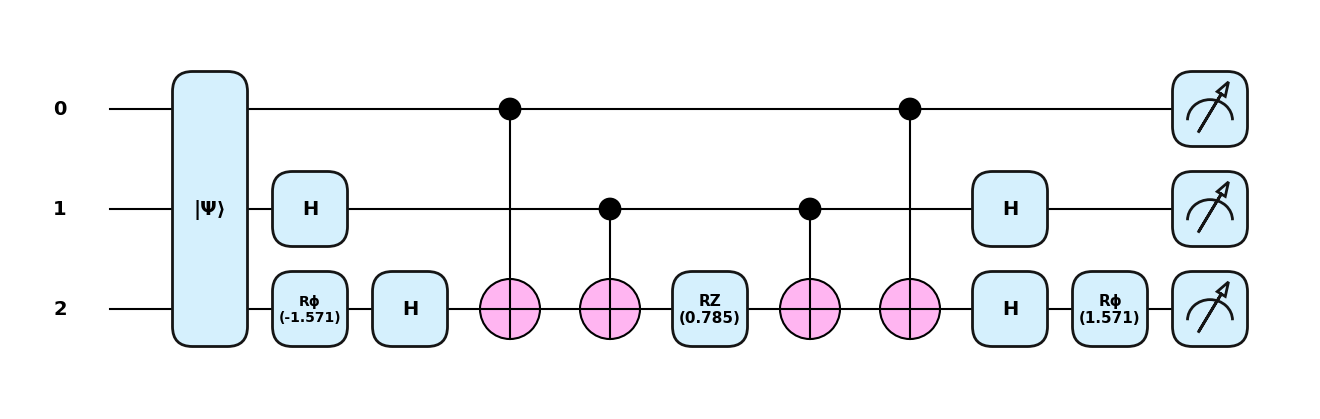







In [ ]:
# @title Circuito Cuantico de la exponencial
def exp_P_native(c, P, dt):
    if set(P) == {"I"}:
        return                         # término puramente escalar
    θ = 2 * c * dt                     # porque RZ(θ) = e^{-i θ/2 Z}

    active = [q for q, p in enumerate(P) if p in "XYZ"]

    # Cambio de base X→Z, Y→Z
    for q in active:
        if P[q] == "X":
            qml.Hadamard(wires=q)
        elif P[q] == "Y":
            qml.PhaseShift(-np.pi/2, wires=q)
            qml.Hadamard(wires=q)

    # Entrelazamos paridad en el último qubit activo
    target = active[-1]
    for q in active[:-1]:
        qml.CNOT(wires=[q, target])

    qml.RZ(θ, wires=target)

    # Deshacer entrelazado
    for q in reversed(active[:-1]):
        qml.CNOT(wires=[q, target])

    # Regreso de base
    for q in active:
        if P[q] == "X":
            qml.Hadamard(wires=q)
        elif P[q] == "Y":
            qml.Hadamard(wires=q)
            qml.PhaseShift(np.pi/2, wires=q)

# Creamos el dispositivo y el QNode
dev = qml.device("default.qubit", wires=3)

@qml.qnode(dev)
def circuit_ZXY():
    # Preparamos el estado |000>
    qml.BasisState(np.array([0, 0, 0]), wires=[0, 1, 2])

    # Implementamos exp(-i θ Z₀ X₁ Y₂) con θ = π/4
    # Para que 2*c*dt = θ => c=1, dt=θ/2=π/8
    exp_P_native(1, ["Z", "X", "Y"], np.pi/8)

    return qml.state()

# Ejecutamos el circuito
# state = circuit_ZXY()
# qml.draw_mpl(circuit_ZXY, decimals=3,style = "pennylane")() # Linea que Grafica el circuito cuantico

### **Codificación del operador $\hat{a}$**

Para simular la dinámica de un campo bosónico en un computador cuántico digital, es necesario **truncar la base infinita de Fock** en un número finito de niveles. Esto se debe a que un sistema de $n$ qubits solo puede representar $2^n$ estados distintos, lo que limita la dimensión efectiva del espacio de Hilbert accesible para la simulación. En consecuencia, la base de Fock se truncará en $N = 2^n$ niveles, y los estados $|n\rangle$ se codificarán como cadenas binarias de longitud $n$, de modo que cada nivel corresponde a una configuración específica del registro de qubits.

Por ejemplo, en el caso de 2 qubits, se pueden representar los siguientes 4 niveles de Fock con sus respectivas codificaciones binarias:

| Estado de Fock | Representación binaria |
|----------------|------------------------|
| $|0\rangle$     | $|00\rangle$           |
| $|1\rangle$     | $|01\rangle$           |
| $|2\rangle$     | $|10\rangle$           |
| $|3\rangle$     | $|11\rangle$           |

A partir de esta codificación, podemos construir el operador de aniquilación bosónico $a$, que actúa disminuyendo en una unidad el número de fotones de un estado dado. En la base de Fock truncada, su forma matricial es:

$$
a = \sum_{n=1}^{N-1} \sqrt{n} \, |n-1\rangle\langle n|
$$

Cada término $\sqrt{n} \, |n-1\rangle\langle n|$ representa una transición entre dos estados consecutivos de Fock, y su implementación en un computador cuántico requiere encontrar operadores que reproduzcan dicha transición en el espacio de los qubits. Para lograr esto, es necesario construir versiones digitales del operador $a$, utilizando combinaciones de compuertas cuánticas básicas que actúan sobre los qubits individuales.

En este contexto, se introducen operadores locales que permiten manipular los estados de los qubits de manera controlada.

\begin{align*}
I_+^{(j)} &= \frac{1}{2}(I_j + Z_j) \quad \text{(proyector sobre } |0\rangle \text{ en qubit } j) \\
I_-^{(j)} &= \frac{1}{2}(I_j - Z_j) \quad \text{(proyector sobre } |1\rangle \text{ en qubit } j) \\
\sigma_+^{(j)} &= \frac{1}{2}(X_j + iY_j) \quad \text{(operador de creación en qubit } j) \\
\sigma_-^{(j)} &= \frac{1}{2}(X_j - iY_j) \quad \text{(operador de aniquilación en qubit } j)
\end{align*}

Estos operadores actúan únicamente sobre el qubit indicado, dejando los demás inalterados. Para modelar una transición entre dos estados de Fock (como $|2\rangle \rightarrow |1\rangle$), se necesita construir un **producto tensorial** que reconozca dicha transición en la base binaria y aplique la operación adecuada.Para ello, se debe empezar expresando el operador truncado a cierto numero de qubits, por ejemplo, con 2 qubits, el espacio de Fock truncado tiene dimensión 4. Por tanto, el operador $a$ se expresa como:

$$
a = \sqrt{1} \, |0\rangle\langle 1| + \sqrt{2} \, |1\rangle\langle 2| + \sqrt{3} \, |2\rangle\langle 3|
$$

Cada término de esta suma puede traducirse en una **matriz de dimensión $4 \times 4$**, que a su vez puede descomponerse como una combinación lineal de productos de matrices de Pauli $I, X, Y, Z$, actuando sobre los dos qubits.

\begin{align*}
|00\rangle\langle 01| &= (|0\rangle\langle 0|)_1 \otimes (|0\rangle\langle 1|)_0 = I_+^{(1)} \otimes \sigma_-^{(0)} \\
|01\rangle\langle 10| &= (|0\rangle\langle 1|)_1 \otimes (|1\rangle\langle 0|)_0 = \sigma_-^{(1)} \otimes \sigma_+^{(0)} \\
|10\rangle\langle 11| &= (|1\rangle\langle 1|)_1 \otimes (|0\rangle\langle 1|)_0 = I_-^{(1)} \otimes \sigma_-^{(0)}
\end{align*}

De esta forma, el operador a queda transcrito a compuertas de pauli como:

\begin{align*}
a &= I_+^{(1)} \otimes \sigma_-^{(0)}
   +\sqrt{2}  \sigma_-^{(1)} \otimes \sigma_+^{(0)}
   +\sqrt{3}  I_-^{(1)} \otimes \sigma_-^{(0)}
\end{align*}

Basta sustituir las identidades por sus expresiones en términos de matrices de Pauli para obtener cadenas de operadores Pauli con los coeficientes adecuados, que pueden integrarse en exponenciales e implementarse directamente en circuitos cuánticos. Con esta representación, el módulo genera una versión del operador \$a\$ que actúa fielmente sobre el espacio de Fock truncado, permitiendo tanto la construcción de Hamiltonianos como el cálculo de magnitudes dinámicas —como funciones de correlación o valores esperados—. Con ello culmina esta sección, resaltando la relevancia de la transformación de operadores para la simulación cuántica.



### **¿Como medir un estado sin colapsarlo?**

Para extraer información intermedia de un estado cuántico sin destruir su coherencia durante la simulación temporal, se podría imaginar un procedimiento en bucle que alterna evolución cuántica y medida en cada intervalo. En este enfoque, se crea primero el estado inicial y luego, en cada paso de tiempo, se avanza el circuito y se realiza una medición interna para recolectar los observables deseados sin finalizar la simulación.

**Algoritmo 1 (medidas “in situ”)**  
- Crear el estado inicial  
- Para cada paso en la secuencia temporal:  
  - Avanzar la simulación un intervalo de tiempo  
  - Medir el estado sin colapsar la simulación  

Sin embargo, PennyLane impone que cualquier medida dentro de un QNode colapsa el estado y detiene la ejecución cuántica. Por ello, el Algoritmo 1 no es viable en este entorno, y se adopta un segundo enfoque que separa la evolución y la medida: en cada iteración se simula un avance completo, se extrae externamente el vector de estado para medir los observables, y luego se reinyecta ese mismo estado en el simulador para continuar la dinámica.  

**Algoritmo 2 (separar evolución y medida)**  
- Crear el estado inicial  
- Para cada paso en la secuencia temporal:  
  - Simular un intervalo y devolver el vector de estado  
  - Medir externamente los observables deseados  
  - Reinyectar el estado resultante en el simulador  

Aunque el Algoritmo 2 introduce una sobrecarga al extraer y reinyectar el vector de estado en cada iteración, permite cumplir con la restricción de PennyLane de no medir “in situ” dentro de un QNode. De este modo, se conserva la coherencia del estado cuántico a lo largo de toda la simulación y se obtienen observables intermedios sin colapsar el circuito. Este enfoque se adopta como la solución estándar en el módulo, garantizando tanto la fidelidad de la evolución temporal como la posibilidad de análisis detallados de errores y correlaciones.

En la fase de medida externa, nuestro objetivo es calcular dos valores esperados clave sobre el estado completo $  |\psi\rangle \in \mathcal{H}_{\text{campo}}\otimes\mathcal{H}_{\text{átomo}} $ : la inversión de población atómica  

$$
\langle \sigma_z \rangle = \langle \psi |\, I_{\text{campo}}\otimes \sigma_z \,| \psi\rangle
$$
y el número medio de fotones  
$$
\langle N \rangle = \langle \psi |\, N_{\text{campo}}\otimes I_{\text{átomo}} \,| \psi\rangle.
$$
Para ello construimos explícitamente los operadores en el espacio total de \(n\) qubits.

```python
def pop_inv_n_from_state(self, state):
    # 1. Número de niveles de Fock = 2^{n_qubits-1}
    levels = 2**(self.n_qubits-1)

    # 2. Operador σ_z sobre el qubit del átomo (más significativo)
    #    Z_atom = I_field ⊗ σ_z_atom
    Z_atom = np.kron(
        np.eye(levels),
        np.array([[1, 0],
                  [0, -1]], complex)
    )

    # 3. Operador número N = diag(0,1,...,levels-1) sobre los qubits de campo
    #    qml.Hermitian lo define, wires indica qué qubits, luego qml.matrix extrae la matriz completa
    N_op_pl = qml.Hermitian(
        np.diag(np.arange(levels)),
        wires=[self.n_qubits-1-i for i in range(1, self.n_qubits)]
    )
    n_big = qml.matrix(N_op_pl, wire_order=list(range(self.n_qubits)))

    # 4. Cálculo de expectativas ⟨ψ|O|ψ⟩
    pop_inversion = np.vdot(state, Z_atom @ state).real
    photon_number = np.vdot(state, n_big @ state).real

    return pop_inversion, photon_number
```

En el código, el uso de `np.kron` para $Z_{\rm atom}$ refleja la construcción $I_{\text{campo}}\otimes\sigma_z$. El observable de número fotónico $N$ se define primero como una matriz diagonal en $\mathcal{H}_{\text{campo}}$ y luego se extiende al espacio completo mediante `qml.Hermitian` y `qml.matrix`. Finalmente, los valores esperados se evalúan con productos internos complejos, lo que devuelve valores reales que corresponden a las magnitudes físicas deseadas sin alterar el estado original en el simulador. Con esta estrategia algebraica garantizamos una medida “sin colapso” coherente y reproducible paso a paso.




## **Implementación Computacional por Modulos**

Lo que se busca en esta seccion es organizar el codigo en archivos separados funcionales que organicen labores por separado con la finalidad de introducir cambios que se puedan visualizar en tiempo real y compararlos con soluciones analiticas en tiempo real, de la misma forma una forma de visualizar resultados separados y una forma de generar los documentos de resultados grandes con la comparación de resultados. De esta forma los modulos seleccionados son:



### **Modulo "Init State" o Estado inicial**

Este modulo permite crear el estado inicial de cualquier tipo de simulación que se vaya a implementar, partiendo de los estados iniciales sencillos como estados puros o una superposición de estados con probabilidades establecidas o sin establecer, osea, estados de este tipo:

$$
\begin{aligned}
\text{estado puro:} \quad & \lvert \phi \rangle = \lvert \psi \rangle, \\
\text{superposición de estados puros:} \quad & \lvert \phi \rangle = c_{1}\,\lvert \psi_{1} \rangle + c_{2}\,\lvert \psi_{2} \rangle, \quad |c_{1}|^{2} + |c_{2}|^{2} = 1
\end{aligned}
$$

Aparte de estos estados es necesario dejar la opción de que se puedan generar estados coherentes y estados comprimidos, para ello se requiere hacer la evolución temporal de un hamiltoniano de esta forma:

$$
D(\alpha) \;=\; \exp\bigl(\alpha\,a^\dagger \;-\;\alpha^*\,a\bigr)
\quad\Longrightarrow\quad
\lvert \alpha \rangle \;=\; D(\alpha)\,\lvert 0 \rangle
$$

$$
S(\zeta) \;=\; \exp\!\Bigl(\tfrac{1}{2}\bigl(\zeta^*\,a^2 \;-\;\zeta\,a^{\dagger 2}\bigr)\Bigr)
\quad\Longrightarrow\quad
\lvert \zeta \rangle \;=\; S(\zeta)\,\lvert 0 \rangle
$$

Para hacer esto es necesario saber como construir el operador a truncado a un numero de qubits, para ello se implementa un algoritmo que se describe en el articulo [qubitization of bosons](https://arxiv.org/pdf/2105.12563). Este algoritmo nos permite construir el operador a truncado a un diferente numero de qubits, este algoritmo queda descrito en el [Apéndice A](#apendice-a)

Este algoritmo es muy util dado que una vez obtenido el operador a se deberia  construir de la misma forma $a^\dagger$, pero si se tiene en cuenta que al final solo seran cadenas de pauli que son hermiticas, entonces el operador $a^\dagger$ es simplemente conjugar los coeficientes asociados al operador a, y mantener las cadenas de pauli.

Lo que implica que la construcción de los operadores se simplifica significativamente, por ejemplo si en el caso del estado inicial coherente se toma un $\alpha$ real para el operador desplazamiento del estado coherente, entonces $$a-a^\dagger = 2*i*Re(a)$$

computacionalmente solo es separar los coeficientes reales de este operador con las respectivas cadenas de pauli y hacer la evolución temporal desde el estado base hasta t=alpha.

In [ ]:
import pennylane as qml
import numpy as np

class InitState:
    """
    Prepara |psi_field> ⊗ |psi_atom> con compuertas, consistente con:
      - Átomo en wire = n_qubits-1
      - Campo en wires = [0, 1, ..., n_qubits-2]  (little-endian)
    y con la medición:
      Z_atom = kron(I_levels, Z)
      N      = Hermitian(diag(0..levels-1)) sobre los wires del campo (en ese orden).
    """
    def __init__(self, n_qubits: int):
        self.n_qubits = n_qubits
        self.device = qml.device("lightning.qubit", wires=n_qubits)

    def createState(self, Atom=None, Aprobs=None, Field=None, Fprobs=None):
        """
        Atom:   lista de estados ['g'] | ['e'] | ['g','e']  (orden libre)
        Aprobs: pesos no normalizados para Atom (si None → uniforme)

        Field:  lista de niveles [n] o [n1, n2, ...]
        Fprobs: pesos no normalizados para Field (si None → uniforme)

        Convención del átomo para cuadrar con Z_atom = diag(+1,-1):
          |e> ↔ |0>, |g> ↔ |1>.
        """
        # ----- valores por defecto -----
        if Atom  is None: Atom  = ['g']
        if Field is None: Field = [0]

        N  = self.n_qubits
        Nf = N - 1
        atom_wire   = N - 1
        # LITTLE-ENDIAN para el campo: q0 es LSB, qN-2 MSB
        field_wires = list(range(Nf))  # [0, 1, ..., N-2]

        # --- Normalización de pesos ---
        # Átomo
        if Aprobs is None:
            Aprobs = [1] * len(Atom)
        p_atom = np.array(Aprobs, dtype=float)
        p_atom /= p_atom.sum()

        # Campo
        if Fprobs is None:
            Fprobs = [1] * len(Field)
        p_field = np.array(Fprobs, dtype=float)
        p_field /= p_field.sum()

        @qml.qnode(self.device)
        def prep():
            # ===== Campo =====
            dim_field = 2 ** Nf
            amp_field = np.zeros(dim_field, dtype=complex)

            if len(Field) == 1:
                n = Field[0]
                amp_field[n] = 1.0
            else:
                for n_i, w in zip(Field, p_field):
                    amp_field[n_i] = np.sqrt(w)

            # Normalizar
            norm = np.linalg.norm(amp_field)
            if norm == 0:
                raise ValueError("Las probabilidades de Field son todas cero.")
            amp_field /= norm

            # Preparación sobre wires little-endian
            qml.MottonenStatePreparation(amp_field, wires=field_wires)

            # ===== Átomo =====
            if len(Atom) == 1:
                s = Atom[0].lower()
                if s == 'g':
                    qml.PauliX(wires=atom_wire)
            else:
                p_e = sum(w for s, w in zip(Atom, p_atom) if s.lower() == 'e')
                # cos²(θ/2) = p_e → θ = 2 arccos(√p_e)
                theta = 2 * np.arccos(np.sqrt(p_e))
                qml.RY(theta, wires=atom_wire)

            return qml.state()

        return prep

    def coherentState(self, alpha, builder, atom=None, dt=0.01):
        """
        Genera un estado coherente mediante evolución trotterizada desde |0...0>.
        - Si atom in {None, []}: usa TODOS los n_qubits para el CAMPO coherente.
        - Si atom=['g'] / ['e'] / ['g','e']: usa (n_qubits-1) para CAMPO y el último para el ÁTOMO,
          retornando |campo> ⊗ |átomo> (átomo en el último wire).

        Convención del átomo: |g> = [0, 1], |e> = [1, 0].
        """
        # --- configuración de tamaños ---
        N = self.n_qubits
        atom_list = [] if (atom is None or len(atom) == 0) else list(atom)
        use_atom = len(atom_list) > 0
        n_field_qubits = N if not use_atom else N - 1

        # --- ket del átomo (solo si aplica) ---
        if use_atom:
            ket_g = np.array([0.0, 1.0], dtype=np.complex128)  # |g>
            ket_e = np.array([1.0, 0.0], dtype=np.complex128)  # |e>

            if len(atom_list) == 1:
                s = atom_list[0].lower()
                if s == 'g':
                    ket_atom = ket_g
                elif s == 'e':
                    ket_atom = ket_e
                else:
                    raise ValueError(f"Estado atómico desconocido: {atom_list[0]}")
            elif len(atom_list) == 2:
                # superposición equiprobable normalizada
                ket_atom = (ket_g + ket_e) / np.sqrt(2.0)
            else:
                raise ValueError("atom debe contener 0, 1 o 2 elementos: 'g', 'e'")

        # --- evolución para preparar el coherente del campo ---
        n_steps = int(alpha / dt)
        if n_steps < 1:
            n_steps = 1

        # Lista de operadores para preparar coherente en el registro de CAMPO
        ops_list = builder.Coherent(dt, n_field_qubits)

        # Estado inicial del CAMPO: |0...0> (vacío)
        dim_field = 2 ** n_field_qubits
        initial_field = np.zeros(dim_field, dtype=np.complex128)
        initial_field[0] = 1.0

        evolver = Evolve(ops_list=ops_list, n_qubits=n_field_qubits)
        result = evolver.run(initial_state=initial_field, n_steps=n_steps)
        psi_field = result["final_state"]  # vector del campo

        # --- armar estado total ---
        if use_atom:
            # campo ⊗ átomo (átomo es el último qubit)
            psi_total = np.kron(psi_field, ket_atom)
            return psi_total
        else:
            # solo campo usando TODOS los n_qubits
            # (ya preparamos el campo en n_field_qubits = N)
            return psi_field









### **Modulo "Evolve" - Evolucion Temporal**

Esta herramienta permite realizar la evolución temporal de cualquier circuito cuántico mediante un esquema de “paso a paso”: en cada intervalo se aplica la unidad, se extrae para su análisis sin colapsar el estado y, a continuación, se utiliza este mismo vector como punto de partida del siguiente tramo de evolución. De esta forma se preserva plenamente la coherencia cuántica y resulta posible inspeccionar el estado intermedio a lo largo de toda la simulación.

Antes de disparar las puertas en el simulador es necesario establecer un orden óptimo para los términos del hamiltoniano. Bajo la hipótesis de que las diferentes contribuciones conmutan (o lo hacen aproximadamente), la troterización admite permutaciones que, aunque equivalentes teóricamente, presentan costes de ejecución muy distintos. La configuración que minimiza el tiempo de cómputo se obtiene siguiendo los pasos especificados en el [Apéndice B](#apendice-b).

Con la secuencia de operaciones ya ordenada, el siguiente paso consiste en disparar únicamente las puertas estrictamente necesarias —cambios de base o entrelazamientos— para cada término. Para ello se desarrolló la función **list_operations_bitmask**, que recorre la lista de operadores y evalua en cada caso la base y el estado de entrelazamiento actuales de los qubits, construye la lista mínima de puertas que debe ejecutar el simulador. Para ello sigue el algoritmo que se presenta a continuación:

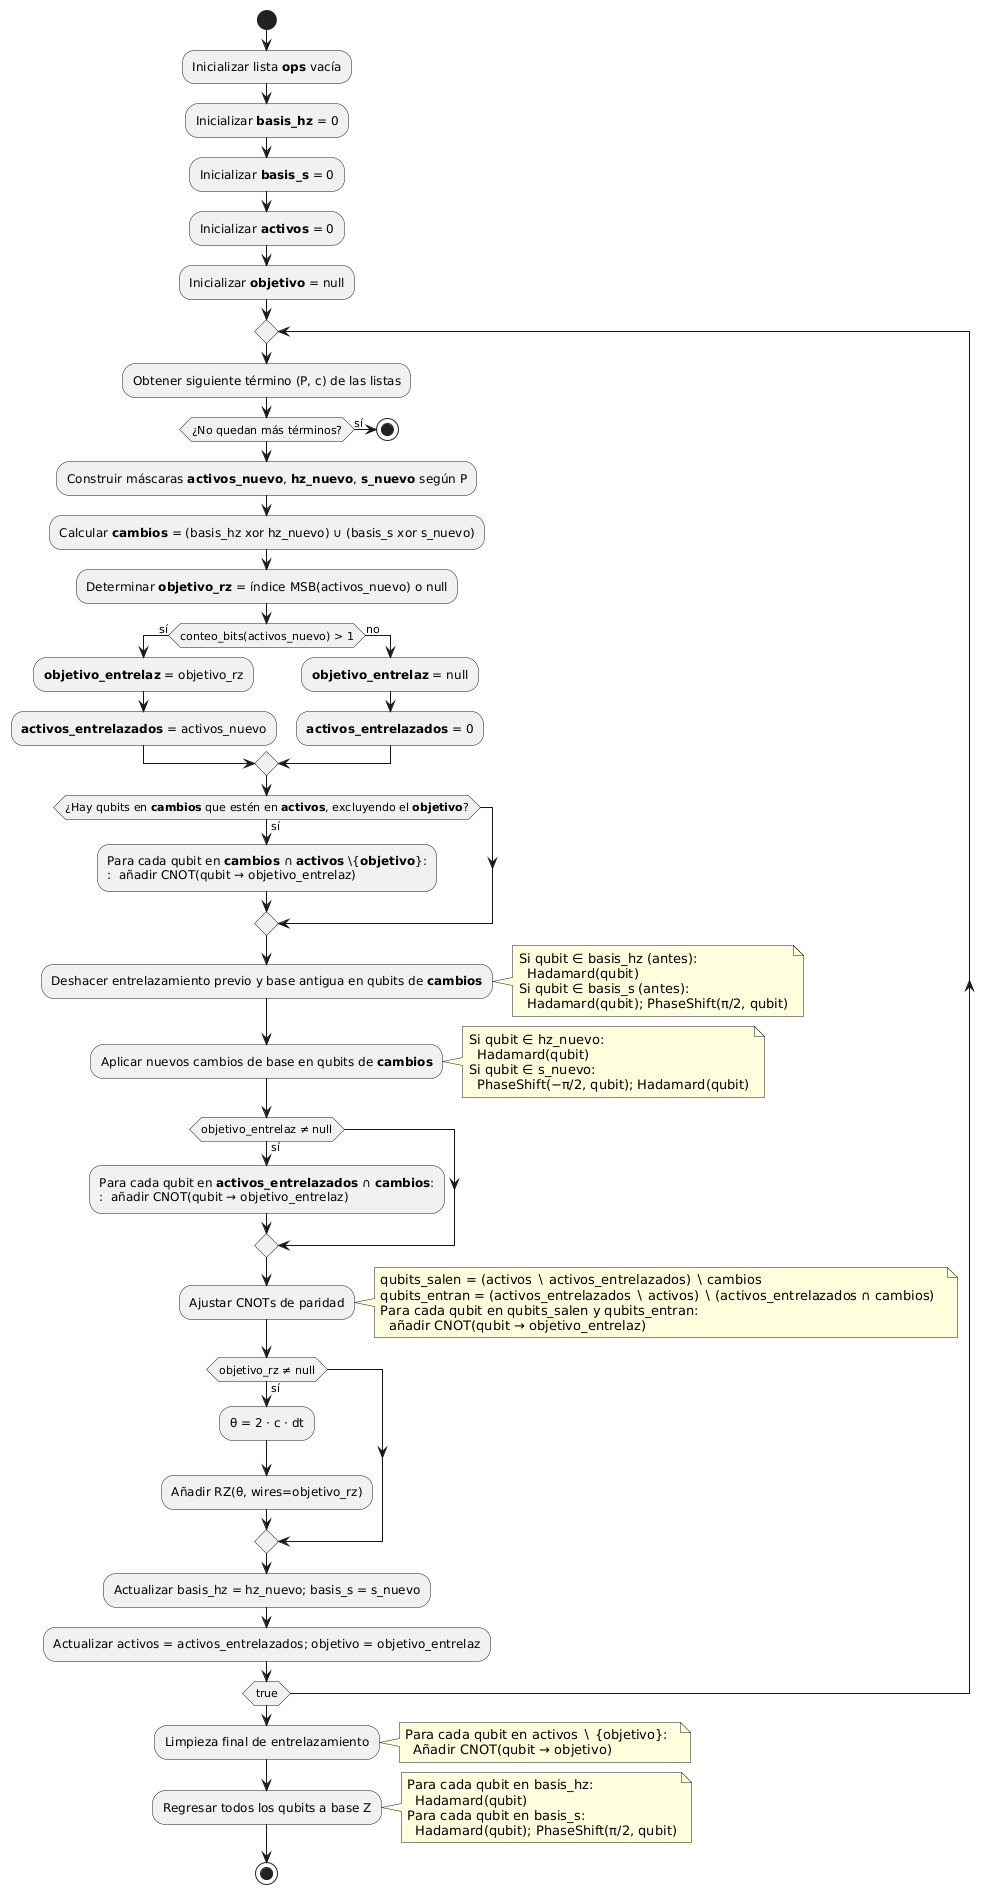


Este algoritmo debe tomar numerosas decisiones en cada paso: identificar qué qubits están entrelazados, cuáles requieren cambio de base y en qué base quedó el término anterior. Si se implementara literalmente cada uno de estos chequeos en tiempo de ejecución, el coste clásico sería prohibitivamente alto, pues aunque el simulador cuántico ejecute pocas puertas, el trabajo de control y actualización sería inmenso. Para evitarlo, hemos incorporado una técnica inspirada en la compilación previa de C++: aunque en un simulador cuántico no exista una fase de “compilación” como tal, la troterización implica repetir idénticamente el mismo conjunto de puertas en cada intervalo de tiempo desde $t=0$ hasta $t=t_f$. Con nuestra función, esas puertas se calculan y almacenan una sola vez en una lista durante la primera iteración, de modo que en cada paso temporal el simulador solo recorre esa lista preconstruida sin volver a tomar decisiones.

Gracias a este enfoque, el coste de control clásico se reduce drásticamente. Al aislar la optimización de las puertas —evitando comprobar en cada paso qué qubits hay que cambiar de base o entrelazar— se acelera el tiempo de cómputo interno del simulador en un factor aproximado de 4. Además, al combinar esta ventaja con la propia ejecución cuántica repetitiva, el rendimiento global del código mejora hasta unas 12 veces respecto a una implementación que evaluara y aplicara dinámicamente todos los cambios de base y entrelazamientos en cada paso.


In [ ]:
import pennylane as qml
import numpy as np
from tqdm import tqdm

# from your_module import pop_inv_n_from_state  # importa tu función de medida
def pop_inv_n_from_state(state, n_qubits):
    """
    Calcula (⟨σ_z⟩, ⟨N⟩) para un vector de estado en n_qubits,
    interpretando little-endian en los qubits de campo.
    """
    levels = 2 ** (n_qubits - 1)

    # σ_z en el qubit átomo (el más significativo, wire = n_qubits-1)
    Z_atom = np.kron(
        np.eye(levels, dtype=complex),
        np.array([[1, 0],
                  [0, -1]], dtype=complex)
    )

    # Número de fotones sobre los qubits de campo [0,1,...,n_qubits-2]
    wire_list = list(range(n_qubits - 1))
    N_op = qml.Hermitian(
        np.diag(np.arange(levels, dtype=complex)),
        wires=wire_list
    )
    N_full = qml.matrix(N_op, wire_order=list(range(n_qubits)))

    pop_inversion = np.vdot(state, Z_atom @ state).real
    photon_number = np.vdot(state, N_full  @ state).real

    return pop_inversion, photon_number


class Evolve:
    """
    Propaga un estado cuántico usando una lista de operaciones Δt
    y mide ⟨σ_z⟩ y ⟨N⟩ usando pop_inv_n_from_state.
    """
    def __init__(self, ops_list, n_qubits: int):
        self.ops_list  = ops_list
        self.n_qubits  = n_qubits
        self.device    = qml.device("lightning.qubit", wires=n_qubits)

        @qml.qnode(self.device)
        def step(prev_state):
            qml.StatePrep(prev_state, wires=range(n_qubits))
            for op in self.ops_list:
                qml.apply(op)
            return qml.state()

        self.step = step

    def run(self, initial_state: np.ndarray, n_steps: int):
        """
        Evoluciona initial_state n_steps veces y siempre mide
        inversión de población y número medio de fotones.
        Devuelve un dict con:
          - 'inversion': array de ⟨σ_z⟩ de longitud n_steps+1
          - 'photon_number': array de ⟨N⟩ de longitud n_steps+1
          - 'final_state': vector de estado tras n_steps pasos
        """
        inv_data = np.zeros(n_steps + 1)
        n_data   = np.zeros(n_steps + 1)

        state = initial_state
        inv, nph = pop_inv_n_from_state(state, self.n_qubits)
        inv_data[0], n_data[0] = inv, nph

        for k in tqdm(range(1, n_steps + 1), desc="Evolving state", unit="step"):
            state = self.step(state)
            inv, nph = pop_inv_n_from_state(state, self.n_qubits)
            inv_data[k], n_data[k] = inv, nph

        return {
            "inversion":      inv_data,
            "photon_number":  n_data,
            "final_state":    state,
        }


### **Modulo "Analitycs" o Analitico**

Este modulo se encarga de recrear los datos que se quieren encontrar con el modelo planteado computacionalmente, por ejemplo, si se quiere generar un estado coherente de valor $\alpha$, se podria utilizar:

$$
|\alpha\rangle = e^{-\frac{|\alpha|^2}{2}} \sum_{n=0}^{\infty} \frac{\alpha^n}{\sqrt{n!}} |n\rangle
$$

Al comparar un estado coherente con su expansión teórica en la base de Fock, es posible evaluar las probabilidades de ocupación de cada nivel y así contrastarlas con los resultados obtenidos en simulaciones. Sin embargo, dado que este tipo de estado requiere, en principio, una superposición infinita de niveles, es fundamental considerar el error introducido al truncar la base.

Este error se vuelve más significativo a medida que el sistema se aproxima al límite de representación impuesto por la cantidad de qubits disponibles. Por ejemplo, si se utilizan 3 qubits, solo se pueden representar 8 estados $|n\rangle$, desde $n = 0$ hasta $n = 7$. En ese caso, el valor máximo de $\alpha$ para evitar un truncamiento severo estaría acotado por $\alpha_{\text{max}} = \sqrt{7}$. De manera general, si la simulación se realiza con $n$ qubits, el número máximo de estados accesibles es $2^n$, y por tanto el valor recomendado es:


$$
\alpha_{\text{max}} = \sqrt{2^n - 1}
$$

Este límite proporciona una guía práctica para seleccionar $\alpha$ de forma que el estado coherente simulado conserve una buena fidelidad con respecto a su descripción ideal.

Aunque la comparación entre estados iniciales es un componente importante de este módulo, su verdadero valor radica en la posibilidad de contrastar modelos físicos completos, como el de Jaynes-Cummings o el modelo de Rabi. Estas comparaciones se enfocan particularmente en la evolución temporal de un sistema desde un estado inicial específico, permitiendo evaluar cómo se propaga el sistema bajo diferentes condiciones y dinámicas cuánticas. Esta capacidad es esencial cuando se busca validar la fidelidad de las simulaciones realizadas en un computador cuántico frente a las soluciones analíticas.

Para facilitar esta comparación, el módulo se apoya en la biblioteca **QuTiP**, una herramienta robusta y ampliamente validada para simular la dinámica de sistemas cuánticos abiertos y cerrados. Con QuTiP, es posible realizar propagaciones temporales precisas bajo Hamiltonianos bien definidos, utilizando distintos estados iniciales. Esto permite obtener una referencia confiable que sirva como base para contrastar los resultados generados por el simulador cuántico, ya sea mediante métodos trotterizados, circuitos variacionales u otros enfoques digitales.

Este proceso comparativo es crucial, ya que permite estudiar cómo fluctúan los errores introducidos por distintas fuentes, como el truncamiento del espacio de Hilbert, errores por ruido en las compuertas, o imprecisiones en la implementación del Hamiltoniano. Para cuantificar estas desviaciones, se utilizan métricas como el error cuadrático medio (RMS) o el error promedio. De esta manera, el módulo proporciona una herramienta completa para analizar la evolución de sistemas cuánticos desde una perspectiva analítica y computacional, evaluando con rigor el desempeño del hardware cuántico frente a soluciones teóricas exactas.



In [ ]:
# ─── jc_qutip_super.py (v3, añade campo coherente) ───────────────────
import numpy as np, math, qutip as qt
from math import exp

class JCqutipSuper:
    """
    Evolución exacta de
      H = ω_f a†a + (ω_a/2)σ_z + (λ/2)(σ₊a + σ₋a†)
    con estado inicial tensorial independiente átomo–campo.

    Novedad: Field puede ser
      - lista/iterable de enteros (como antes): niveles de Fock con probabilidades Fprobs
      - ('coh', alpha)                          estado coherente con dimensión autoajustada
      - ('coh', alpha, dim)                     coherente con dimensión explícita
    """

    def __init__(self, lam, ω_f=1.0, ω_a=1.0, n_extra=3, eps=1e-10):
        self.lam, self.ωf, self.ωa = lam, ω_f, ω_a
        self.pad = n_extra       # relleno adicional de Fock para discretos
        self.eps = eps           # tolerancia de cola para coherente
        self.sz, self.sp, self.sm = qt.sigmaz(), qt.sigmap(), qt.sigmam()

    # ---------- utilidades de dimensión ----------
    def _dim_field_discrete(self, n_max):
        return int(n_max) + 1 + self.pad

    def _dim_field_coherent(self, alpha):
        """Elige dim mínima tal que P(N > dim-1) <= eps para Poisson(|α|^2)."""
        lam = float(abs(alpha)**2)
        # Heurística inicial: media ± k*sqrt(media)
        n = max(0, int(lam + 8*max(1.0, lam**0.5)))
        # Asegura que la cola esté por debajo de eps
        tail = 1.0
        # calcula cola (1 - CDF) sumando desde 0 hasta n
        # si no basta, incrementa n
        while True:
            # CDF(n) para Poisson(λ)
            cdf = 0.0
            term = exp(-lam)
            cdf += term
            for k in range(1, n+1):
                term *= lam / k
                cdf += term
            tail = 1.0 - cdf
            if tail <= self.eps:
                break
            n = int(n * 1.25 + 5)  # crece un poco y reintenta
        # dim es n+1 (niveles 0..n)
        return (n + 1)

    # ---------- Hamiltoniano ----------
    def _hamiltonian(self, dim):
        a = qt.destroy(dim); adag = a.dag(); N = adag*a
        Hfree = ( self.ωf*qt.tensor(qt.qeye(2), N)
                + 0.5*self.ωa*qt.tensor(self.sz, qt.qeye(dim)) )
        Hint  = 0.5*self.lam*(qt.tensor(self.sm, adag)+qt.tensor(self.sp, a))
        return Hfree + Hint, N

    # ---------- átomo (igual que antes) ----------
    def _atom_ket(self, Atom, Aprobs):
        Atom = ['g','e'] if not Atom else list(Atom)
        pA = np.ones(len(Atom)) if Aprobs is None else np.asarray(Aprobs, float)
        pA /= pA.sum()
        # ket átomo (|e>≡|0>, |g>≡|1>)
        amp_a = np.zeros(2, complex)
        for s, w in zip(Atom, pA):
            amp_a[1 if s.lower()=='g' else 0] = math.sqrt(w)
        return qt.Qobj(amp_a, dims=[[2],[1]])

    # ---------- campo: discreto o coherente ----------
    def _field_ket_and_dim(self, Field, Fprobs):
        """
        Field:
          - iterable de ints → discreto como antes
          - ('coh', alpha) o ('coh', alpha, dim) → coherente
        """
        # coherente por tupla ('coh', alpha[, dim])
        if (isinstance(Field, tuple) or isinstance(Field, list)) and len(Field)>=2 \
           and isinstance(Field[0], str) and Field[0].lower().startswith('coh'):
            alpha = complex(Field[1])
            dim   = int(Field[2]) if len(Field) >= 3 else self._dim_field_coherent(alpha)
            ket_f = qt.coherent(dim, alpha)
            return ket_f, dim

        # diccionario {'coh': alpha, 'dim': opcional}
        if isinstance(Field, dict) and any(k in Field for k in ('coh','coherent')):
            alpha = complex(Field.get('coh', Field.get('coherent')))
            dim   = int(Field.get('dim', self._dim_field_coherent(alpha)))
            ket_f = qt.coherent(dim, alpha)
            return ket_f, dim

        # caso discreto (retrocompatible)
        Field = [0] if not Field else list(Field)
        pF = np.ones(len(Field)) if Fprobs is None else np.asarray(Fprobs, float)
        pF /= pF.sum()
        dim_f = self._dim_field_discrete(max(Field))
        amp_f = np.zeros(dim_f, complex)
        for n, w in zip(Field, pF):
            amp_f[int(n)] = math.sqrt(w)
        ket_f = qt.Qobj(amp_f, dims=[[dim_f],[1]])
        return ket_f, dim_f

    # ---------- Estado inicial tensorial ----------
    def _state(self, Atom, Field, Aprobs, Fprobs):
        ket_a = self._atom_ket(Atom, Aprobs)
        ket_f, dim_f = self._field_ket_and_dim(Field, Fprobs)
        return qt.tensor(ket_a, ket_f), dim_f

    # ---------- Evolución ----------
    def evolve(self, Atom, Field, t_vals, Aprobs=None, Fprobs=None):
        ψ0, dim = self._state(Atom, Field, Aprobs, Fprobs)
        Htot, N = self._hamiltonian(dim)
        res = qt.sesolve(Htot, ψ0, np.asarray(t_vals, float),
                         e_ops=[qt.tensor(self.sz, qt.qeye(dim)),
                                qt.tensor(qt.qeye(2), N)])
        return map(np.real, res.expect)


### Modulo "Hamiltonians" - Hamiltonianos

La clase `Hamiltonians` tiene como objetivo principal **construir la lista de operaciones cuánticas** necesarias para simular la dinámica de sistemas físicos gobernados por Hamiltonianos conocidos, como el **modelo de Jaynes-Cummings (JC)**. Esta lista es esencial para que el simulador cuántico digital pueda propagar estados utilizando secuencias de compuertas que representen fielmente el sistema físico original.

El Hamiltoniano de Jaynes-Cummings se puede separar de la siguiente manera:

$$
H_{\text{JC}} = \underbrace{\omega a^\dagger a}_{\text{Campo}} + \underbrace{\frac{\omega_0}{2} \sigma_z}_{\text{Átomo}} + \underbrace{g (a^\dagger \sigma_- + a \sigma_+)}_{\text{Interacción}}
$$

---

## Representación del campo y del átomo

La primera parte del proceso consiste en representar los términos individuales del Hamiltoniano del campo y del átomo.

1. **Término del campo**: $\omega a^\dagger a$

   * Este término representa el número de fotones y equivale al **operador número** en la base de Fock.
   * En un simulador cuántico digital, este operador se implementa como una **compuerta de rotación $R_z$** sobre cada nivel de la base truncada, ponderada por su número de ocupación $n$.
   * Para una base truncada hasta $N$, se crea un operador diagonal con entradas $n \omega$ para $n = 0, 1, \dots, N-1$, lo cual puede ser implementado como una secuencia controlada de rotaciones en Z.

2. **Término del átomo**: $\frac{\omega_0}{2} \sigma_z$

   * Este término describe la energía del sistema de dos niveles.
   * Se implementa directamente como una rotación $R_z(\omega_0 t)$ en el qubit correspondiente al átomo.


### Construcción del término de interacción

El término de interacción en el modelo de Jaynes-Cummings está dado por:

$$
H_{\text{int}} = g (a^\dagger \sigma_- + a \sigma_+)
$$

Para implementarlo en un simulador cuántico digital, es fundamental reescribir este acoplamiento de manera que separe los operadores bosónicos (correspondientes al campo) de los operadores del átomo (qubit). Esto se puede lograr utilizando la identidad:


$$
a^\dagger \sigma_- + a \sigma_+ = \frac{1}{2} \left[ (a + a^\dagger) \sigma_x + i(a - a^\dagger) \sigma_y \right]
$$


Este resultado se obtiene a partir de las siguientes igualdades:

* $\sigma_+ + \sigma_- = \sigma_x$
* $i(\sigma_+ - \sigma_-) = \sigma_y$

Reemplazando en el Hamiltoniano, el término de interacción se puede reescribir como:

$$
H_{\text{int}} = \frac{g}{2} (a + a^\dagger) \sigma_x + \frac{g}{2} i (a - a^\dagger) \sigma_y
$$

o equivalentemente,

$$
H_{\text{int}} = g \left[ \mathrm{Re}(a) \cdot \sigma_x - \mathrm{Im}(a) \cdot \sigma_y \right]
$$


### Interpretación para implementación digital

Esta expresión permite una implementación natural en un simulador cuántico:

1. **La parte real del operador $a$**, es decir $\mathrm{Re}(a) = \frac{a + a^\dagger}{2}$, actúa **multiplicada por una compuerta $\sigma_x$** en el qubit que representa el átomo.

2. **La parte imaginaria del operador $a$**, es decir $\mathrm{Im}(a) = \frac{a - a^\dagger}{2i}$, se aplica junto a una **compuerta $-\sigma_y$**.

Por tanto, la evolución generada por el término de interacción toma la forma:

$$
U_{\text{int}}(t) = \exp\left[-i t \cdot g \left( \mathrm{Re}(a) \cdot X - \mathrm{Im}(a) \cdot Y \right)\right]
$$

Esto implica que el operador del campo (truncado en la base de Fock) actúa como una matriz real fija en el subespacio bosónico, mientras que las compuertas **Pauli-X** y **Pauli-Y** actúan sobre el qubit del átomo. En términos de implementación cuántica, se traduce en una **lista de operaciones controladas o entrelazadas**, donde cada término puede ser expresado como una evolución trotterizada o como parte de una matriz bloque que actúa sobre el espacio compuesto campo-átomo.



### Resultado de la clase `Hamiltonians`

La clase `Hamiltonians` retorna una **lista ordenada de operaciones cuánticas** que representan los términos del Hamiltoniano seleccionado (por ejemplo, Jaynes-Cummings), expresados en términos de **compuertas cuánticas elementales**. Esta lista constituye la base para aplicar la evolución del sistema en un simulador cuántico digital.

Cada entrada en la lista corresponde a un componente del Hamiltoniano trotterizado o exacto, e incluye la información necesaria para construir el circuito cuántico equivalente. Específicamente, la lista contiene:

* Las **rotaciones Z** necesarias para simular el término del campo bosónico $\omega a^\dagger a$, con su valor de frecuencia y nivel truncado.
* Las **rotaciones Z** correspondientes al átomo, representando $\frac{\omega_0}{2} \sigma_z$.
* Los términos de **interacción** $g(a^\dagger \sigma_- + a \sigma_+)$, reescritos como combinaciones de operadores reales e imaginarios de $a$, multiplicados por compuertas $X$ y $Y$ sobre el átomo.
* Los tiempos de evolución o escalas de trotterización asociadas a cada operación.
* El orden en que deben aplicarse las operaciones para garantizar consistencia con el modelo físico y eficiencia computacional.

Esta estructura modular permite que otros componentes del simulador, como el motor de propagación temporal o el generador de circuitos, utilicen esta lista para construir la dinámica cuántica paso a paso.


In [ ]:
import pennylane as qml
import numpy as np
import math
# from Funciones_Globales import (
#     generate_interaction_hamiltonian,
#     ordenar_dynamic,
#     list_operations_bitmask,
# )

class HamiltonianBuilder:
    def __init__(self, n_qubits: int, ω_f: float, ω_a: float, lam: float):
        self.n_qubits = n_qubits
        self.ω_f      = ω_f
        self.ω_a      = ω_a
        self.lam      = lam

    # en HamiltonianBuilder

    def field_ops(self, dt):
        Nf = self.n_qubits - 1
        wires_big = list(range(Nf))[::-1]          # MSB → wire 0
        return [
            qml.RZ(-self.ω_f * 2**i * dt, wires=w)   # ← sin “/2”
            for i, w in enumerate(wires_big)
        ]

    def atom_ops(self, dt):
        atom_wire = self.n_qubits - 1
        return [qml.RZ(self.ω_a * dt, wires=atom_wire)]  # ← ω_a * dt (no /2)


    def anihilation_operator(self,n_field):

        # Mapa de expansión de operadores simbólicos a Pauli
        numeric_map = {
            'Sm': [('X', 1), ('Y', -1j)],
            'Sp': [('X', 1), ('Y', 1j)],
            'Im': [('I', 1), ('Z', -1)],
            'Ip': [('I', 1), ('Z', 1)],
        }

        # Acumulador de términos tipo 'XZIY' : coeficiente complejo
        acc = defaultdict(complex)

        # Expansión con generador
        for idx, term in enumerate(generate_sequences(n_field), start=1):
            base = math.sqrt(idx)
            mapped = [numeric_map[op] for op in term]

            for combo in itertools.product(*mapped):  # combina todas las opciones Pauli
                letters = ''.join([L for L, _ in combo])
                coef = base
                for _, c in combo:
                    coef *= c
                if abs(coef) > 1e-10:
                    acc[letters] += coef

        # Separación real e imaginaria
        real_products, real_coeffs = [], []
        imag_products, imag_coeffs = [], []
        for p, c in acc.items():
            if abs(c.real) > 1e-10:
                real_products.append(p)
                real_coeffs.append(c.real)
            if abs(c.imag) > 1e-10:
                imag_products.append(p)
                imag_coeffs.append(c.imag)

        real_coeffs = [coef/2**(n_field) for coef in real_coeffs]
        imag_coeffs = [coef/2**(n_field) for coef in imag_coeffs]

        # Invertir cada producto de Pauli (p.ej. "XZYI" → "IYZX")
        real_products = [p[::-1] for p in real_products]
        imag_products = [p[::-1] for p in imag_products]

        return real_products, real_coeffs, imag_products, imag_coeffs

    def Coherent(self,dt,n_qubits):
        Lx,Cx,Ly,Cy = self.anihilation_operator(n_qubits)

        # 2) Ordeno sólo las cadenas
        keys_ord = ordenar_dynamic(Ly)

        # 3) Reordeno los coeficientes aplicando la misma permutación
        idx_map    = {k: i for i, k in enumerate(Ly)}
        coeffs_ord = [2*Cy[idx_map[k]]*dt for k in keys_ord]

        return transition_sequence_collect_ops(keys_ord,coeffs_ord)



    def int_JC(self, dt: float):
        # Usa la función real que tienes en Funciones_Globales:
        Lx, Coef_X, Ly, Coef_Y = self.anihilation_operator(self.n_qubits-1)

        pauli_X = [s + "X" for s in Lx]
        pauli_Y = [s + "Y" for s in Ly]
        coeffs  = Coef_X + [-c for c in Coef_Y]

        Nf = self.n_qubits - 1
        keys    = pauli_X + pauli_Y
        ordered = ordenar_dynamic(keys)
        idx_map = {k: i for i, k in enumerate(keys)}

        coeffs_dt = [coeffs[idx_map[k]] * (self.lam/2 ) * dt for k in ordered]

        # return transition_sequence_collect_ops(ordered, coeffs_dt,Nf)
        return transition_sequence_collect_ops(ordered, coeffs_dt)





# Implementaciones de Casos de Ejemplo


Este módulo reúne una colección de implementaciones diseñadas para explorar y simular la dinámica de sistemas cuánticos en el marco del **modelo de Jaynes–Cummings** y variantes relacionadas. Su objetivo es ofrecer un entorno flexible, en el que cada componente —preparación de estados, construcción del Hamiltoniano, propagación temporal y análisis de observables— pueda utilizarse de forma independiente o integrada, según las necesidades del estudio.

A lo largo de los diferentes ejemplos se muestran casos típicos y configuraciones iniciales variadas, así como herramientas para validar resultados frente a soluciones de referencia. La estructura modular busca mantener una correspondencia clara entre las entidades físicas del sistema y los bloques funcionales del código, favoreciendo la legibilidad, la reutilización y la extensión a nuevos escenarios. Más que centrarse en parámetros numéricos concretos, el enfoque está en ilustrar métodos y flujos de trabajo que permitan adaptar la simulación a distintos regímenes, condiciones iniciales y objetivos de análisis.





## Ejemplo 1: Atomo superpuesto - Campo superpuesto

Este ejemplo muestra la evolución de un sistema **átomo de dos niveles + campo bosónico** bajo el **modelo de Jaynes–Cummings** (JC), partiendo de un átomo en superposición $|g\rangle$ y $|e\rangle$ y un campo en un estado de Fock definido. La construcción sigue la lógica física del modelo: primero se fija el número total de qubits para representar de forma truncada el espacio conjunto átomo–campo, después se definen los parámetros característicos del sistema (frecuencias y acoplamiento) y se establece la estructura del Hamiltoniano, separando los términos de evolución libre y el acoplamiento entre subsistemas. Esta separación permite entender y manipular la dinámica en términos de los procesos físicos que intervienen: oscilaciones propias del átomo y del campo, y transferencia de excitaciones entre ambos.

La preparación del estado inicial y su propagación se plantean de manera coherente con esta estructura física: se define explícitamente el estado compuesto del átomo y del campo y se hace evolucionar mediante una sucesión de pasos temporales, imitando la evolución continua del modelo. Los observables de interés —como la inversión atómica y el número medio de fotones— permiten seguir el intercambio de energía característico del JC, mientras que la comparación con un cálculo de referencia exacto asegura que la dinámica simulada respeta la física subyacente. En conjunto, el ejemplo ilustra no solo cómo reproducir las oscilaciones del modelo JC, sino también cómo organizar la simulación de forma que cada parte del código corresponda a un bloque conceptual del sistema físico, facilitando su extensión a otras configuraciones iniciales o ajustes de parámetros.


Evolving state: 100%|██████████| 1200/1200 [00:18<00:00, 65.13step/s]


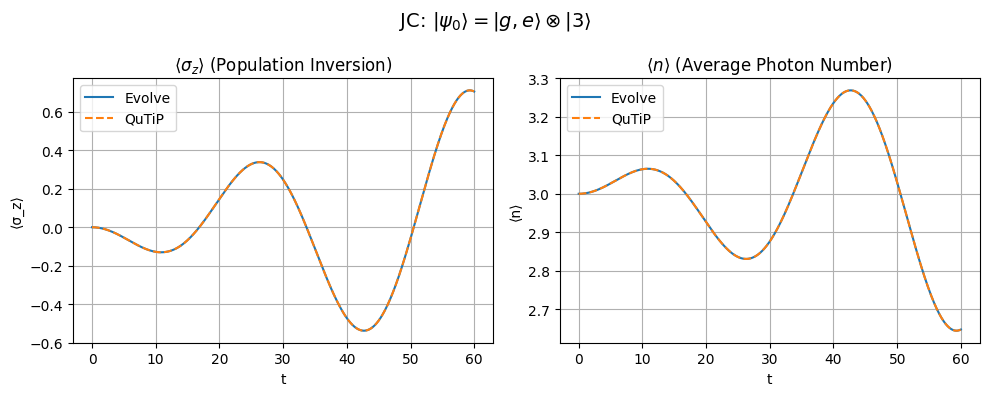

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Parámetros generales
n_qubits = 4             # 2 de campo + 1 átomo
dt       = 0.05
t_final  = 60.0
n_steps  = int(t_final / dt)
t_vals   = np.linspace(0, t_final, n_steps + 1)

atom  = ['g','e']        # superposición átomo
field = [3]               # campo fijo n=3

# 2) Lista de puertas Δt  (libres + interacción)
builder  = HamiltonianBuilder(n_qubits, ω_f=1.0, ω_a=1.0, lam=0.1)
free_ops = builder.field_ops(dt) + builder.atom_ops(dt)   # ω-f y ω-a
int_ops  = builder.int_JC(dt)                         # interacción JC
ops_list = free_ops + int_ops

# 3) Estado inicial (superposición)
init  = InitState(n_qubits)
psi0  = init.createState(Atom=atom, Field=field)()     # ← ¡llama al QNode!

# 4) Evolución numérica (Evolve)
evolver  = Evolve(ops_list=ops_list, n_qubits=n_qubits)
results  = evolver.run(initial_state=psi0, n_steps=n_steps)
inv_num  = results["inversion"]
n_num    = results["photon_number"]

# 5) Evolución exacta con QuTiP
qt_solver     = JCqutipSuper(lam=0.1, ω_f=1.0, ω_a=1.0)
inv_ref, n_ref = qt_solver.evolve(atom, field, t_vals)   # ← devuelve las dos series


# 6) Graficar comparación
# fig, axs = plt.subplots(1, 2, figsize=(10, 4))
# Suptitle automático según atom y field
jc_compare(t_vals, inv_num, n_num, inv_ref, n_ref,
           atom=atom, field=field,
           label_num="Evolve", label_ref="QuTiP")
plt.tight_layout(); plt.show()


## Ejemplo 2: Generación de estado coherente para n qubits

Este fragmento genera y valida un **estado coherente** del campo con una construcción modular y parametrizable. Con `HamiltonianBuilder` (que fija los **parámetros físicos clave** del oscilador y su acoplamiento) y `InitState`, se prepara el vector de estado `final_state = prep.coherentState(alpha, builder)` directamente en la base computacional del registro de `n_qubits` (asignados al campo según el layout elegido). A partir de ese estado, se calculan las probabilidades $|c_n|^2$ y se comparan con la **distribución de Poisson** teórica de parámetro $\alpha^2$, truncada a `levels=2**Nf`. La tabla en `pandas` rotula cada nivel de Fock $n$ con su cadena binaria `|...>` tal como está codificada en el registro, y coloca en columnas la probabilidad **numérica** (derivada de las amplitudes) y la **teórica** (Poisson). Este diseño hace explícito el mapeo **Fock→registro** y permite verificar de inmediato efectos de truncamiento: si la masa de Poisson se acerca al borde impuesto por `levels`, la discrepancia queda visible en la comparación.

La **versatilidad** proviene de la separación de responsabilidades y de la ausencia de constantes “horneadas”: `HamiltonianBuilder` define el marco físico (frecuencias, acoplamiento, dimensión efectiva); `InitState` encapsula la receta del estado coherente $|\alpha\rangle$ sin atarla a un $\alpha$ fijo; y la capa de análisis (NumPy + pandas) permite variar sin fricción el **tamaño del registro** (`n_qubits`), el **truncamiento** (`levels`), la **codificación** (binaria u otras), o incluso el **régimen estadístico** (sustituyendo el inicializador por estados térmicos, squeezed o binomiales). El patrón es reutilizable para **pruebas de regresión** (numérico vs. teórico bajo cambios de implementación), para **bancas de error** por truncamiento (barriendo `n_qubits`) y para **exportar** resultados a otros pipelines. Si se integra luego una evolución temporal, expresiones como `n_steps = int(alpha/dt)` pueden rehacerse en función de las escalas dinámicas pertinentes; si solo se caracteriza el estado inicial, el bloque se mantiene independiente y portable.



In [ ]:
import numpy as np, math, pandas as pd

# ---------- parámetros ----------
n_qubits = 4          # total de qubits en tu simulación
Nf       = n_qubits           # qubits de campo  (si hay átomo)
levels   = 2**Nf
alpha    = 1.5
dt = 0.05

n_steps = int(alpha / dt)
builder  = HamiltonianBuilder(n_qubits, ω_f=1.0, ω_a=1.0, lam=0.1)
prep = InitState(n_qubits)
final_state  = prep.coherentState(alpha=alpha, builder=builder)  # ndarray



probs       = np.abs(final_state)**2

# ---------- Poisson teórica ----------
lam       = alpha**2
probs_th  = np.exp(-lam) * lam**np.arange(levels) / np.array(
              [math.factorial(n) for n in range(levels)]
            )

# ---------- tabla ----------
df = pd.DataFrame({
    "n":        np.arange(levels),
    "Estado":   [f"|{n:0{Nf}b}>" for n in range(levels)],
    "Numérico": np.round(probs, 4),
    "Poisson":  np.round(probs_th,    4),
})

print(df.to_string(index=False))

Evolving state: 100%|██████████| 150/150 [00:01<00:00, 93.82step/s]

 n Estado  Numérico  Poisson
 0 |0000>    0.1054   0.1054
 1 |0001>    0.2362   0.2371
 2 |0010>    0.2664   0.2668
 3 |0011>    0.2006   0.2001
 4 |0100>    0.1129   0.1126
 5 |0101>    0.0513   0.0506
 6 |0110>    0.0191   0.0190
 7 |0111>    0.0060   0.0061
 8 |1000>    0.0016   0.0017
 9 |1001>    0.0004   0.0004
10 |1010>    0.0001   0.0001
11 |1011>    0.0000   0.0000
12 |1100>    0.0000   0.0000
13 |1101>    0.0000   0.0000
14 |1110>    0.0000   0.0000
15 |1111>    0.0000   0.0000


## Ejemplo 3: Atomo en superposición - Campo en estado coherente


Este código implementa la evolución de un sistema bipartito **átomo de dos niveles + campo bosónico** bajo el **modelo de Jaynes–Cummings** (JC) utilizando una trotterización de primer orden. La construcción comienza instanciando el `HamiltonianBuilder`, donde se definen los **parámetros físicos clave** del modelo: frecuencia del campo $\omega_f$, frecuencia de transición atómica $\omega_a$ y constante de acoplamiento $\lambda$. El número total de qubits (`n_qubits`) especifica el truncamiento de la dimensión de Hilbert para el campo y la posición del átomo dentro del registro, asegurando que todas las operaciones posteriores se adapten a esta codificación.

La preparación del estado inicial se realiza con `InitState.coherentState(...)`, que genera directamente el **estado completo del sistema** combinando el campo en un estado coherente $|\alpha\rangle$ con el átomo en el estado seleccionado ($|g\rangle$, $|e\rangle$ o superposición). Este diseño oculta la complejidad de ensamblar manualmente el producto tensorial y garantiza que la estructura del registro de qubits y el truncamiento del campo sean coherentes con el `builder`. A partir de ahí, se crean las listas de operadores que representan la **dinámica libre** (campo y átomo) y la **interacción JC**, que son aplicadas secuencialmente en cada paso temporal por la clase `Evolve`. Finalmente, los resultados se comparan con una evolución de referencia calculada con `JCqutipSuper`, asegurando que tanto la codificación del estado inicial como el espacio de Hilbert usado en la simulación y en la referencia sean equivalentes. Este flujo modular permite cambiar estados iniciales, parámetros físicos o esquemas de integración sin alterar la estructura esencial del código.


Evolving state: 100%|██████████| 1200/1200 [00:07<00:00, 168.77step/s]


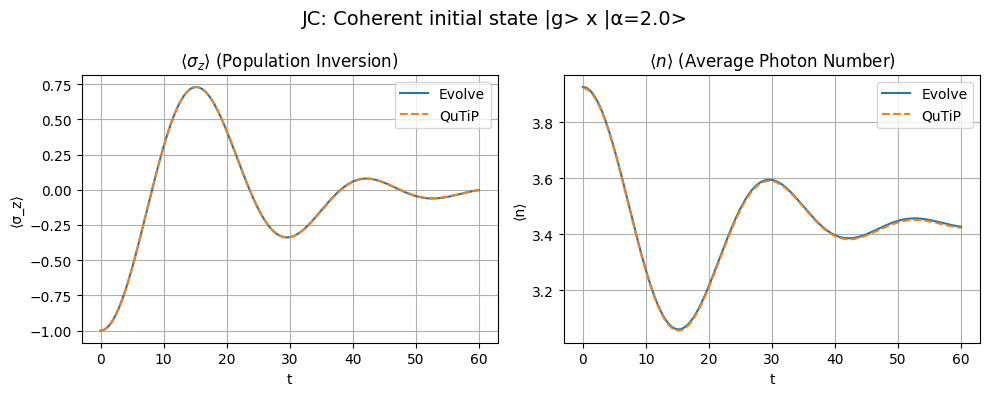

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parámetros generales ---
n_qubits = 4              # 3 de campo + 1 átomo (átomo al final)
dt       = 0.05
t_final  = 60.0
n_steps  = int(t_final / dt)
t_vals   = np.linspace(0, t_final, n_steps + 1)
alpha    = 2.0
atom     = ['g']          # ['g'], ['e'] o ['g','e']

# 1) Builder (antes de preparar el estado coherente)
builder  = HamiltonianBuilder(n_qubits, ω_f=1.0, ω_a=1.0, lam=0.1)

# 2) Estado inicial con TU nuevo método (ya retorna el estado total)
prep  = InitState(n_qubits)
psi0  = prep.coherentState(alpha=alpha, builder=builder, atom=atom)  # ndarray

# 3) Lista de puertas Δt (libres + interacción)
free_ops = builder.field_ops(dt) + builder.atom_ops(dt)   # ω_f y ω_a
int_ops  = builder.int_JC(dt)                             # interacción JC
ops_list = free_ops + int_ops

# 4) Evolución numérica
evolver  = Evolve(ops_list=ops_list, n_qubits=n_qubits)
results  = evolver.run(initial_state=psi0, n_steps=n_steps)
inv_num  = results["inversion"]
n_num    = results["photon_number"]

# 5) Evolución exacta con QuTiP (requiere JCqutipSuper v3 con soporte ('coh', alpha, dim))
field = ('coh', alpha, 2**(n_qubits-1))   # coherente con dim=8 para comparar “manzana con manzana”
qt_solver      = JCqutipSuper(lam=0.1, ω_f=1.0, ω_a=1.0)
inv_ref, n_ref = qt_solver.evolve(atom, field, t_vals)   # devuelve iterables (map)

bigTitle = f"JC: Coherent initial state |{','.join(atom)}> x |α={alpha}>"

# 6) Graficar comparación
jc_compare(t_vals, inv_num, n_num, inv_ref, n_ref,
           atom=atom, field=field,
           suptitle=bigTitle,
           label_num="Evolve", label_ref="QuTiP")
plt.tight_layout(); plt.show()


Evolving state: 100%|██████████| 15000/15000 [13:38<00:00, 18.32step/s]


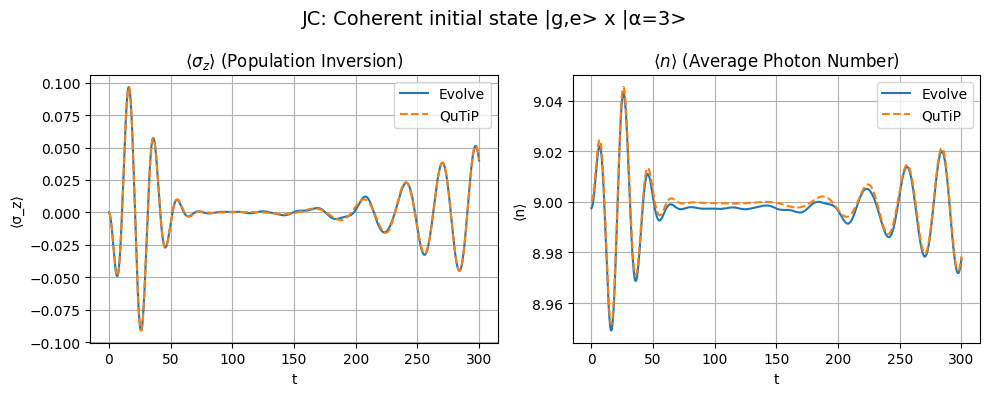

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parámetros generales ---
n_qubits = 6              # 3 de campo + 1 átomo (átomo al final)
dt       = 0.02
t_final  = 300.0
n_steps  = int(t_final / dt)
t_vals   = np.linspace(0, t_final, n_steps + 1)
alpha    = 3
atom     = ['g','e']          # ['g'], ['e'] o ['g','e']

# 1) Builder (antes de preparar el estado coherente)
builder  = HamiltonianBuilder(n_qubits, ω_f=1.0, ω_a=1.0, lam=0.1)

# 2) Estado inicial con TU nuevo método (ya retorna el estado total)
prep  = InitState(n_qubits)
psi0  = prep.coherentState(alpha=alpha, builder=builder, atom=atom)  # ndarray

# 3) Lista de puertas Δt (libres + interacción)
free_ops = builder.field_ops(dt) + builder.atom_ops(dt)   # ω_f y ω_a
int_ops  = builder.int_JC(dt)                             # interacción JC
ops_list = free_ops + int_ops

# 4) Evolución numérica
evolver  = Evolve(ops_list=ops_list, n_qubits=n_qubits)
results  = evolver.run(initial_state=psi0, n_steps=n_steps)
inv_num  = results["inversion"]
n_num    = results["photon_number"]

# 5) Evolución exacta con QuTiP (requiere JCqutipSuper v3 con soporte ('coh', alpha, dim))
field = ('coh', alpha, 2**(n_qubits-1))   # coherente con dim=8 para comparar “manzana con manzana”
qt_solver      = JCqutipSuper(lam=0.1, ω_f=1.0, ω_a=1.0)
inv_ref, n_ref = qt_solver.evolve(atom, field, t_vals)   # devuelve iterables (map)

bigTitle = f"JC: Coherent initial state |{','.join(atom)}> x |α={alpha}>"

# 6) Graficar comparación
# Suptitle personalizado
jc_compare(t_vals, inv_num, n_num, inv_ref, n_ref,
           atom=atom, field=field,
           suptitle=bigTitle,
           label_num="Evolve", label_ref="QuTiP")
plt.tight_layout(); plt.show()


In [ ]:
2**5-1
import numpy as np

np.sqrt(31)

np.float64(5.5677643628300215)

# Apendices

Aqui van los apendices


<a name="apendice-a"></a>
## Apendice A

Para la implementación de este algoritmo es esencial determinar como se iban a organizar los terminos del operador a, para esto es necesario observar, los operadores a tomando n como referencia del numero de qubits.

$$
\begin{aligned}
\text{n=1:}\quad & \hat{a}_{1} = \sigma_{+}^{1} \\
\text{n=2:}\quad & \hat{a}_{2}
  = I_{+}^{1}\sigma_{+}^{2}
  + \sqrt{2}\,\sigma_{+}^{1}\sigma_{-}^{2}
  + \sqrt{3}\,I_{-}^{1}\sigma_{+}^{2} \\
\text{n=3:}\quad & \hat a_{3}
= I_{+}^{1} I_{+}^{2} \sigma_{+}^{3}
+ \sqrt{2}\,I_{+}^{1} \sigma_{+}^{2} \sigma_{-}^{3}
+ \sqrt{3}\,I_{+}^{1} I_{-}^{2} \sigma_{+}^{3}
+ \sqrt{4}\,\sigma_{+}^{1} \sigma_{-}^{2} \sigma_{-}^{3}
+ \sqrt{5}\,I_{-}^{1} I_{+}^{2} \sigma_{+}^{3}
+ \sqrt{6}\,I_{-}^{1} \sigma_{+}^{2} \sigma_{-}^{3}
+ \sqrt{7}\,I_{-}^{1} I_{-}^{2} \sigma_{+}^{3}
\end{aligned}
$$

Se puede observar que los terminos se van repitiendo, sin tener en cuenta las constantes, solo hay que fijarse en las cadenas de operadores, la cual no depende necesariamente de los superindices,ya que si se mantiene el orden de los operadores se podria omitir ese superindice y simplemente mantener todo el tiempo que la cadena se aplicara de izquierda a derecha sobre el qubit inicial hasta el qubit final, entonces el algoritmo para hallar los terminos de $a_{n+1}$ a partir de los terminos de $a_{n}$ , se cosntruye de la siguiente forma:

1. Se construye a partir de tomar los terminos de $a_{n}$ y multiplicarlos por izquierda por $I_{+}$ lo cual se sobreentiende que movera todos los superindices (que se omiten) uno mas adelante.

2. Se debe construir un operador de la forma $\sigma_{+}$ en la primera posicion y luego $\sigma_{-}$ n veces, para dar una cadena de n+1 terminos.

3. Se construye a partir de tomar los terminos de $a_{n}$ y multiplicarlos por izquierda por $I_{-}$ lo cual se sobreentiende que movera todos los superindices (que se omiten) uno mas adelante.

Repitiendo estos pasos n veces se puede construir el operador a para n+1 qubits, por ejemplo, tomando $\hat{a}_{1} = \sigma_{+}^{1} $, entonces:

1. los primeros terminos son $I_{+}^{1}\sigma_{+}^{2}$
2. la segunda lista seria $\sigma_{+}^{1}\sigma_{-}^{2}$
3. Finalmente el ultimo termino seria $I_{-}^{1}\sigma_{+}^{2}$

y se multiplican los terminos en orden, entonces:

$$\hat{a}_{2}
  = I_{+}^{1}\sigma_{+}^{2}
  + \sqrt{2}\,\sigma_{+}^{1}\sigma_{-}^{2}
  + \sqrt{3}\,I_{-}^{1}\sigma_{+}^{2}$$

repitiendo el procedimiento para hallar $\hat{a}_{3}$, entonces:

1. Los primeros términos son  $\quad I_{+}^{1} I_{+}^{2} \sigma_{+}^{3},\quad I_{+}^{1} \sigma_{+}^{2} \sigma_{-}^{3},\quad I_{+}^{1} I_{-}^{2} \sigma_{+}^{3}.$
2. la segunda lista seria $\sigma_{+}^{1}\sigma_{-}^{2} \sigma_{-}^{3} $
3. Finalmente los ultimos terminos seran $\quad I_{-}^{1} I_{+}^{2} \sigma_{+}^{3} ,\quad I_{-}^{1} \sigma_{+}^{2} \sigma_{-}^{3}
,\quad I_{-}^{1} I_{-}^{2} \sigma_{+}^{3}$

si se toma los terminos en ese orden y se multiplica por la raiz de su posicion se obtiene:

$$ \hat a_{3}
= I_{+}^{1} I_{+}^{2} \sigma_{+}^{3}
+ \sqrt{2}\,I_{+}^{1} \sigma_{+}^{2} \sigma_{-}^{3}
+ \sqrt{3}\,I_{+}^{1} I_{-}^{2} \sigma_{+}^{3}
+ \sqrt{4}\,\sigma_{+}^{1} \sigma_{-}^{2} \sigma_{-}^{3}
+ \sqrt{5}\,I_{-}^{1} I_{+}^{2} \sigma_{+}^{3}
+ \sqrt{6}\,I_{-}^{1} \sigma_{+}^{2} \sigma_{-}^{3}
+ \sqrt{7}\,I_{-}^{1} I_{-}^{2} \sigma_{+}^{3}
$$ \\

Una vez obtenido el algoritmo, solo queda entender que en python se puede agregar elementos a una lista simplemente sumando las listas, y de la misma forma usando listas se pueden construir los terminos separados como una lista de listas, de esta forma se pueden obtener resultados como:



```python
# Secuencias generadas por generate_sequences(n_field)
sequences_n1 = [['Sp']]
sequences_n2 = [['Sp', 'Ip'], ['Sm', 'Sp'], ['Sp', 'Im']]
sequences_n3 = [['Sp', 'Ip', 'Ip'],['Sm', 'Sp', 'Ip'],['Sp', 'Im', 'Ip'],
                ['Sm', 'Sm', 'Sp'],
                ['Sp', 'Ip', 'Im'],['Sm', 'Sp', 'Im'],['Sp', 'Im', 'Im']]
print(sequences_n1)
print(sequences_n2)
print(sequences_n3)
```

por ende, solo queda tener en cuenta que en el articulo se toman los elementos como 1,2,3, en el codigo usado en este documento, se toman como 3,2,1,0, por ende se ordenan al reves.

Una vez tenido estos terminos solo queda reemplazar cada termino de esta forma:
$$
\begin{aligned}
\mathrm{Sp} &= X + i\,Y,\\
\mathrm{Sm} &= X - i\,Y,\\
\mathrm{Ip} &= I + Z,\\
\mathrm{Im} &= I - Z.
\end{aligned}
$$

una vez reemplazada se obtienen cadenas de compuertas pauli de la forma: $XYXY$, las cuales vendran acompañadas de los respectivos coeficientes que seran combinaciones de las raices que se toman dentro del operador a, pero una vez llevados a cadenas de pauli, solamente se requiere aplicar las operaciones cuanticas respetando lo que se vio en el marco teorico.



In [ ]:
# @title Codigo Generador de Operadores $a_n$
import pandas as pd

def generate_sequences(n_field):
    if n_field == 1:
        yield ['Sp']
        return
    def grow(prev_a, j):
        ip_branch = [term + ['Ip'] for term in prev_a]
        im_branch = [term + ['Im'] for term in prev_a]
        sp_branch = [['Sm'] * (j - 1) + ['Sp']]
        new_a = ip_branch + sp_branch + im_branch
        if j == n_field:
            for term in new_a:
                yield term
        else:
            yield from grow(new_a, j + 1)
    yield from grow([['Sp']], 2)

# Generate and display sequences for n_field = 1, 2, 3
for n in [1, 2, 3]:
    seqs = list(generate_sequences(n))
    print(f"a_{n}: {seqs}")

In [ ]:
# @title Circuito Cuantico de la exponencial Largo $XIIX:  C_2, YIIY: C_1,$

# Creamos el dispositivo y el QNode
dev = qml.device("default.qubit", wires=3)

@qml.qnode(dev)
def circuit_ZXY():
    # Preparamos el estado |000>
    qml.BasisState(np.array([0, 0, 0,0]), wires=[0, 1, 2,3])

    # Implementamos exp(-i θ Z₀ X₁ Y₂) con θ = π/4
    # Para que 2*c*dt = θ => c=1, dt=θ/2=π/8
    exp_P_native(1, ["X", "I","I", "X"], np.pi/8)
    exp_P_native(1, ["X", "Z","I", "X"], np.pi/8)


    return qml.state()

# Ejecutamos el circuito
# state = circuit_ZXY()
qml.draw_mpl(circuit_ZXY, decimals=3,style = "pennylane")()

<a name="apendice-b"></a>
## Apendice B - Reduccion de Compuertas

Partiendo del hecho de tener una cantidad de operaciones con una cantidad igual de constantes por ejemplo, el modelo usando 3 qubits para el campo y uno para el atomo, tiene una cantidad de operaciones de esta forma:


```python
pauli_terms = {
        # -------- número de fotones (ω n̂) + átomo libre --------
        "IIII":  3.5 * ω,"ZIII": -0.5 * ω,"IZII": -1.0 * ω,"IIZI": -2.0 * ω,
        "IIIZ":  ω0 / 2.0,

        # ------------------- interacción ----------------------
        "XIIX":  f *  C1, "YIIY":  f * -C1,
        "XZIX":  f *  C2, "YZIY":  f * -C2,
        "XIZX":  f *  C3, "YIZY":  f * -C3,
        "XZZX":  f *  C4, "YZZY":  f * -C4,

        "XXIX":  f *  C5, "XXZX":  f *  C6,
        "YXIY":  f *  C5, "YXZY":  f *  C6,
        "YYIX":  f *  C5, "YYZX":  f *  C6,
        "XYIY":  f * -C5, "XYZY":  f * -C6,
        
        "YYYY":  f *  2, "XXXX":  f *  2,
        "YXYX":  f *  2, "XXYY":  f * -2,    
        "YXXY":  f *  2, "XYXY":  f *  2,    
        "XYYX":  f *  2, "YYXX":  f * -2, }
```

Entonces, el algoritmo debe ser capaz de encontrar la minima cantidad de compuertas necesarias para producir este circuito cuántico,sin embargo,los terminos del atomo y el campo conmutan y son irreducibles ya que son operaciones directas sobre un solo qubit,por ende para la reducción de compuertas se tomaran en cuenta solo los terminos de interaccion.

Para entender como encontrar el circuito irreducible, se debe partir del circuito mas general posible, por ende la opción es recorrer termino a termino y realizar los cambios de base y aplicar las CNOT's secuencialmente, lo cual nos da un circuito en el que no se toma en cuenta ningún tipo de optimización o eficiencia, pero que es funcional. Este tipo de circuitos seran la base para encontrar el circuito mas largo, por ejemplo, tomemos los primeros dos terminos del termino de interaccion, para simular, el circuito cuantico sin optimizar correspondiente a: $XIIX:  C_2, YIIY: C_1,$ para ello es necesario realizar los cambios de base, entrelazar los qubits correspondientes usando CNOT's y posteriormente realizar una rotación en Z sobre el qubit objetivo. Lo que resulta en:

$$
\begin{aligned}
\exp\bigl(-i\theta\,X_{0}I_{1}I_{2}X_{3}\bigr)
&= \bigl[H_{0}\bigr]\bigl[H_{3}\bigr]\,
     C_{03}\;\bigl[RZ_{3}(2\theta)\bigr]\;C_{03}\,
   \bigl[H_{3}\bigr]\bigl[H_{0}\bigr]
\end{aligned}
$$


$$
\begin{aligned}
\exp\bigl(-i\theta\,X_{0}Z_{1}I_{2}X_{3}\bigr)
&= \bigl[H_{0}\bigr]\bigl[H_{3}\bigr]\,
   C_{03}\;C_{13}\;\bigl[RZ_{3}(2\theta)\bigr]\;C_{13}\;C_{03}\,
   \bigl[H_{3}\bigr]\bigl[H_{0}\bigr]
\end{aligned}
$$

Para realizar la optimización de compuertas, se parte de esta expresión:

$$
\begin{aligned}
&\exp\bigl(-i\theta\,X_{0}I_{1}I_{2}X_{3}\bigr)\;\exp\bigl(-i\theta\,X_{0}Z_{1}I_{2}X_{3}\bigr) =\;[H_{0}]\,[H_{3}]\;C_{03}\;RZ_{3}(2\theta)\;C_{03}\;[H_{3}]\,[H_{0}]\;
      [H_{0}]\,[H_{3}]\;C_{03}\;C_{13}\;RZ_{3}(2\theta)\;C_{13}\;C_{03}[H_{3}]\,[H_{0}]
\end{aligned}
$$

Se toma en cuenta que las compuertas tienen su inverso, entonces resulta en:
$$
\begin{aligned}
H_{i}H_{i} &= I, & S_j(\theta)\,S_j^{\dagger}(\theta) &= I, & C_{ij}\,C_{ij} &= I
\end{aligned}
$$
Al reemplazar estas identidades en la multiplicación de exponenciales, se observa que:
$$
\begin{aligned}
C_{03}\,H_{3}\,H_{0}\,H_{0}\,H_{3}\,C_{03}
&\xrightarrow{H_{0}H_{0}=I}\;C_{03}\,H_{3}\,I\,H_{3}\,C_{03}
\xrightarrow{H_{3}H_{3}=I}\;C_{03}\,I\,C_{03}
\xrightarrow{C_{03}C_{03}=I}\;I
\end{aligned}
$$

Lo que resulta en una expresión con menos compuertas, simplificada e irreducible.

$$
\begin{aligned}
&\exp\bigl(-i\theta\,X_{0}I_{1}I_{2}X_{3}\bigr)\;\exp\bigl(-i\theta\,X_{0}Z_{1}I_{2}X_{3}\bigr) = [H_{0}]\,[H_{3}]\;RZ_{3}(2\theta)\;C_{13}\;RZ_{3}(2\theta)\;C_{13}\;C_{03}\;[H_{3}]\,[H_{0}]
\end{aligned}
$$

Este circuito tiene la siguiente forma y se puede comparar con el anterior para verificar que efectivamente da el mismo resultado.


In [ ]:
# @title Circuito Cuantico de la exponencial Corto

import pennylane as qml
import numpy as np

# 1) Definimos el dispositivo de 4 qubits
dev = qml.device("default.qubit", wires=4)

# 2) Lista de operaciones (en el mismo orden que aparecen en el diagrama)
#    - Preparamos el estado |Ψ> en los 4 qubits
#    - Luego aplicamos 3 bloques idénticos de (base-change + CNOT + RZ + CNOT + base-undo)
#    - Finalmente medimos (o devolvemos el estado)
psi = np.array([...])  # vector de 16 amplitudes de tu |Ψ>

@qml.qnode(dev)
def circuit_ZXY():
    # — State preparation
    qml.BasisState(np.array([0, 0, 0,0]), wires=[0, 1, 2,3])


    # — 1er bloque
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=3)
    qml.CNOT(wires=[0, 3])
    qml.RZ(0.785, wires=3)
    # qml.CNOT(wires=[0, 3])
    # qml.Hadamard(wires=0)
    # qml.Hadamard(wires=3)

    # # — 2º bloque
    # qml.Hadamard(wires=0)
    # qml.Hadamard(wires=3)
    # qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[1, 3])

    qml.RZ(0.785, wires=3)
    qml.CNOT(wires=[1, 3])

    qml.CNOT(wires=[0, 3])
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=3)

    # # — 3er bloque (controles sobre q1 y q2)
    # #    Aquí el control se reparte en los dos qubits intermedios...
    # qml.CNOT(wires=[1, 3])
    # qml.CNOT(wires=[2, 3])
    # qml.RZ(0.785, wires=3)
    # qml.CNOT(wires=[2, 3])
    # qml.CNOT(wires=[1, 3])

    # Ya estamos de nuevo en la base original; devolvemos el estado o lo medimos
    return qml.state()

# 3) Dibujamos el circuito con matplotlib al estilo “pennylane”
qml.draw_mpl(circuit_ZXY, decimals=3, style="pennylane")()

ModuleNotFoundError: No module named 'pennylane'

Por ende, al ordenar las operaciones cuanticas según los cambios de base, se puede obtener de 3 a 4 veces menos operaciones que en el circuito extendido, ya que las operaciones para cambiar de base de Z a Y son 2 y de Z a x es una sola.

Para llevar esto a un caso extremo en el cual se ordenaran todas las operaciones del termino de interacción se usa el agoritmo de peso ponderado, sobre el cual se tomaran en cuenta solo las configuraciones que tengan menos cambios de base al ordenar las operaciones, dando como resultado que las operaciones que se mencionan al principio se ejecuten de esta forma:

```python
q_0 : YYYYYYYYYYYYXXXXXXXXXXXX  
q_1 : IIZZYXXXYYYXIIZZXXXXYYYY  
q_2 : IZIZYIZXIZXYIZIZIZXYZIXY  
q_3 : YYYYYYYYXXXXXXXXXXXYYYYX
```
Por ende, el q0 solamente necesitara hacer un cambio de base a la mitad, el q3, tambien reduce los cambios de base considerablemente, el q1 y q2, son los que mas cambios de base tienen, pero que de alguna forma, son cambios de base necesarios y seria muy complejo hacer reducciones, por lo que este algoritmo arroja una lista con el orden en el que se deben llevar a cabo las operaciones para que halla el minimo de cambios de base posibles.


